In [21]:
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt


def extract_bounding_box(image_path, xml_path):
    # Load the image
    image = cv2.imread(image_path)

    # Parse the XML file
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Extract bounding box coordinates
    for obj in root.findall(".//object"):
        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)

        # Crop the bounding box from the image
        cropped_image = image[ymin:ymax, xmin:xmax]

        # Save or display the cropped image
    plt.imshow(image)
    # plt.imshow(cropped_image)


# Example usage
image_path = "archive(2)/05102009102.jpg"
xml_path = "archive(2)/05102009102.xml"


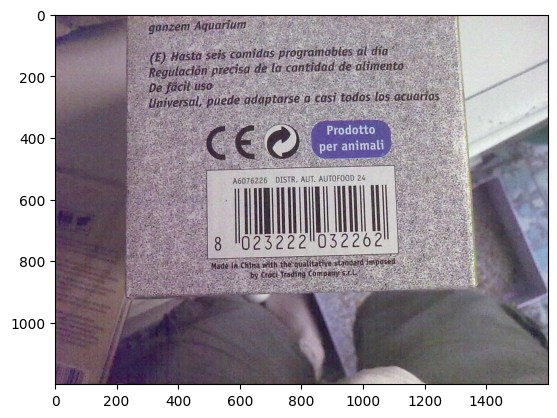

In [22]:
extract_bounding_box(image_path, xml_path)

In [23]:
import os
import shutil


def move_xml_files(source_dir, destination_dir):
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    # Iterate through all files in the source directory
    for file in os.listdir(source_dir):
        if file.endswith(".xml"):
            source_path = os.path.join(source_dir, file)
            destination_path = os.path.join(destination_dir, file)

            # Move the XML file
            shutil.move(source_path, destination_path)


# Example usage
source_directory = "archive(2)"
destination_directory = "xml_files"

move_xml_files(source_directory, destination_directory)

In [24]:
import cv2
import os
import xml.etree.ElementTree as ET


def extract_bounding_boxes(image_dir, xml_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterate through all XML files
    for xml_file in os.listdir(xml_dir):
        if not xml_file.endswith(".xml"):
            continue

        # Parse the XML file
        xml_path = os.path.join(xml_dir, xml_file)
        tree = ET.parse(xml_path)
        root = tree.getroot()

        # Load the corresponding image
        image_file = root.find(".//filename").text
        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)

        # Extract bounding boxes
        for i, obj in enumerate(root.findall(".//object")):
            bndbox = obj.find("bndbox")
            xmin = int(bndbox.find("xmin").text)
            ymin = int(bndbox.find("ymin").text)
            xmax = int(bndbox.find("xmax").text)
            ymax = int(bndbox.find("ymax").text)

            # Crop the bounding box from the image
            cropped_image = image[ymin:ymax, xmin:xmax]

            # Generate a unique filename for each cropped barcode
            output_filename = f"{os.path.splitext(image_file)[0]}_barcode_{i}.jpg"
            output_path = os.path.join(output_dir, output_filename)

            # Save the cropped image
            cv2.imwrite(output_path, cropped_image)


# Example usage
image_directory = "archive(2)"
xml_directory = "xml_files"
output_directory = "barcode_images"

extract_bounding_boxes(image_directory, xml_directory, output_directory)


In [1]:
import cv2
import numpy as np

def calculate_optimal_layers(image):
    height, width = image.shape[:2]
    # Number of layers depends on the smallest dimension
    return int(np.log2(min(height, width))) - 1

img = cv2.imread('barcode_images/05102009102_barcode_1.jpg', cv2.IMREAD_GRAYSCALE)
num_layers = calculate_optimal_layers(img)
print("Optimal Layers:", num_layers)


Optimal Layers: 5


In [1]:
import cv2
import numpy as np
from realesrgan import RealESRGAN
import matplotlib.pyplot as plt
img = cv2.imread('blurry_barcode.jpg', cv2.IMREAD_GRAYSCALE)

def laplacian_pyramid(img, levels=7):
    gaussian_pyr = [img]
    for i in range(levels):
        img = cv2.GaussianBlur(img, (5, 5), 0)
        gaussian_pyr.append(img)
    return gaussian_pyr

def focus_stack(layers):
    sharp_layers = []
    for layer in layers[3:]:  # Skip low frequencies
        edges = cv2.Laplacian(layer, cv2.CV_64F)
        sharp_layers.append(edges)
    return sum(sharp_layers) / len(sharp_layers)

def enhance_with_esrgan(image):
    model = RealESRGAN('RealESRGAN_x4plus')
    return model.predict(image)

pyramid = laplacian_pyramid(img)

sharp_image = focus_stack(pyramid)

enhanced = enhance_with_esrgan(sharp_image)

# Plot all 3 images
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title("Original Blurry Barcode")
plt.imshow(img, cmap='gray')

plt.subplot(1, 3, 2)
plt.title("After Focus Stacking")
plt.imshow(sharp_image, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Final Unblurred Barcode (ESRGAN Enhanced)")
plt.imshow(enhanced, cmap='gray')

plt.show()

ModuleNotFoundError: No module named 'torchvision.transforms.functional_tensor'

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def align_image(image, reference):
    sift = cv2.SIFT_create()

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_reference = cv2.cvtColor(reference, cv2.COLOR_BGR2GRAY)

    kp1, des1 = sift.detectAndCompute(gray_image, None)
    kp2, des2 = sift.detectAndCompute(gray_reference, None)

    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    if len(good_matches) < 4:
        print("⚠️ Not enough keypoints for alignment!")
        return np.zeros_like(image)  

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    matrix, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    aligned = cv2.warpPerspective(image, matrix, (reference.shape[1], reference.shape[0]))

    return aligned


def extract_high_freq(image):
    blurred = cv2.GaussianBlur(image, (15, 15), 5)
    return cv2.subtract(image, blurred)

def get_reference_image(blurry_images):
    def high_freq_content(img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return cv2.Laplacian(gray, cv2.CV_64F).var()

    high_freq_values = [high_freq_content(img) for img in blurry_images]

    return blurry_images[np.argmax(high_freq_values)]


def multi_frame_fusion(blurry_images):
    reference = get_reference_image(blurry_images)
    fused = np.zeros_like(reference, dtype=np.float32)

    for img in blurry_images:
        aligned_img = align_image(img, reference)
        high_freq = extract_high_freq(aligned_img)

        high_freq = cv2.warpPerspective(high_freq, np.eye(3), (reference.shape[1], reference.shape[0]))

        fused += high_freq

    fused = cv2.normalize(fused, None, 0, 1, cv2.NORM_MINMAX)#.astype(np.uint)

    return fused

blurry_images = os.listdir("deblurred_stack_images/nb_1")
blurry_images

['Screenshot from 2025-03-16 18-03-38.png',
 'Screenshot from 2025-03-16 18-05-47.png',
 'Screenshot from 2025-03-16 18-05-14.png',
 'Screenshot from 2025-03-16 18-04-32.png',
 'Screenshot from 2025-03-16 18-07-28.png',
 'Screenshot from 2025-03-16 18-06-03.png',
 'Screenshot from 2025-03-16 18-06-44.png',
 'Screenshot from 2025-03-16 18-04-13.png',
 'Screenshot from 2025-03-16 18-07-40.png',
 'Screenshot from 2025-03-16 18-06-19.png',
 'Screenshot from 2025-03-16 18-04-00.png',
 'Screenshot from 2025-03-16 18-07-13.png',
 'Screenshot from 2025-03-16 18-03-48.png',
 'Screenshot from 2025-03-16 18-04-52.png',
 'Screenshot from 2025-03-16 18-03-29.png']

In [20]:
blurr = []
for image in blurry_images:
    blurr.append(cv2.imread(os.path.join("deblurred_stack_images/nb_1", image)))
len(blurr)

15

In [23]:
reconstructed_image.shape

(140, 212, 3)

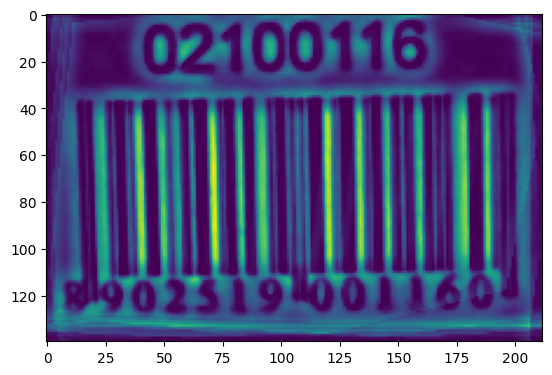

In [ ]:
sharp_image = cv2.imread('clicked_dataset/nb_1.png')

reconstructed_image = multi_frame_fusion(blurr)
plt.imshow(reconstructed_image)


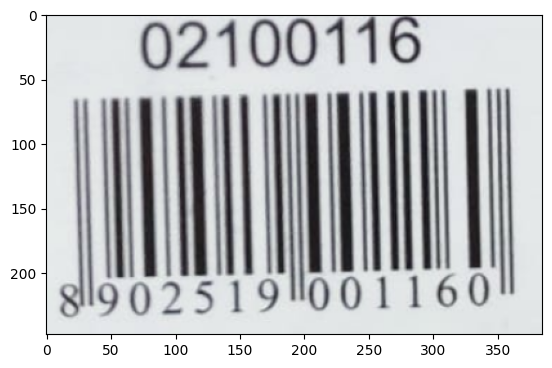

In [4]:
plt.imshow(sharp_image)

In [10]:
image = cv2.imread("clicked_dataset/nb_1/Screenshot from 2025-03-16 18-03-38.png")
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(image, None)

In [4]:
!python predict.py

  0%|                                                     | 0/1 [00:00<?, ?it/s][ WARN:0@4.763] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
/home/roy/unblur_Barcode/DeblurGANv2/models/fpn_inception.py:164: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  map3 = self.td1(lateral3 + nn.functional.upsample(map4, scale_factor=2, mode="nearest"))
/home/roy/unblur_Barcode/DeblurGANv2/models/fpn_inception.py:165: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  map2 = self.td2(F.pad(lateral2, pad, "reflect") + nn.functional.upsample(map3, scale_factor=2, mode="nearest"))
/home/roy/unblur_Barcode/DeblurGANv2/models/fpn_inception.py:166: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  map1 = self.td3(lateral1 + nn.functional.upsample(map2, scale_factor=2, mode="nearest"))
/home/roy/unblur_Barcode/Deblur

In [5]:
!python deblurring.py

(260, 398, 3)


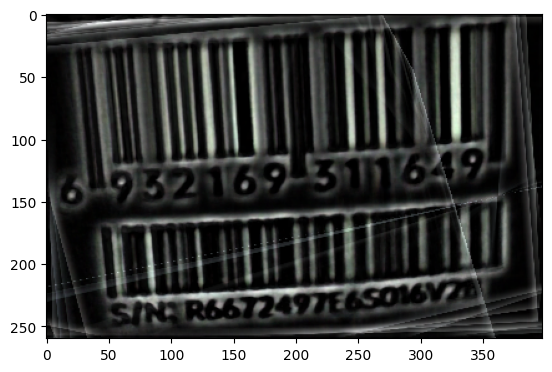

In [2]:
img = cv2.imread("test/reconstructed/hp_1.png")
print(img.shape)
plt.imshow(img)

(1, 1, 3)


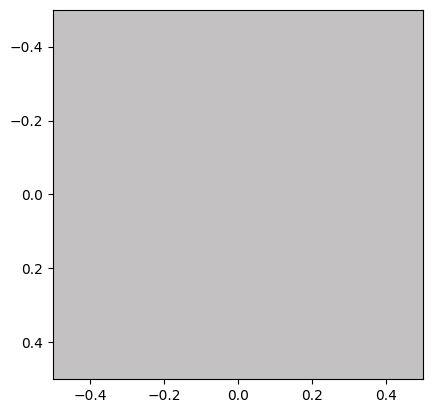

In [5]:
img = cv2.imread("/home/roy/Downloads/output.png")
print(img.shape)
plt.imshow(img)

In [3]:
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=4b5bc38fef7b9b5393664596740ea07789ae256983988e78fc07112f33c769e7
  Stored in directory: /home/roy/.cache/pip/wheels/8b/6f/9b/231a832f811ab6ebb1b32455b177ffc6b8b1cd8de19de70c09
Successfully built efficientnet-pytorch


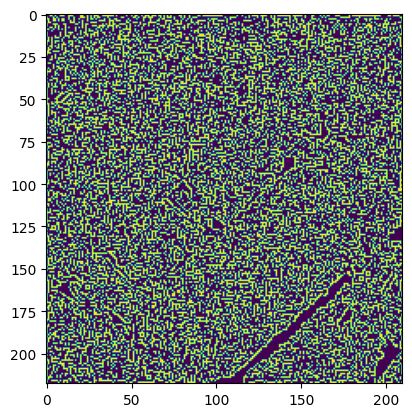

In [ ]:
img = cv2.imread("test/target/op_3.png")

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
edges = cv2.Canny((gray * 255).astype(np.uint8), 100, 200)  # Apply Canny
plt.imshow(edges)

In [ ]:
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import os

class CustomDataset(Dataset):
    def __init__(self, root_dir):
        self.reconstructed_dir = os.path.join(root_dir, "reconstructed")
        self.target_dir = os.path.join(root_dir, "target")
        
        self.reconstructed_files = sorted(os.listdir(self.reconstructed_dir))
        self.target_files = sorted(os.listdir(self.target_dir))

        assert len(self.reconstructed_files) == len(self.target_files), "Mismatch in dataset sizes!"

    def __len__(self):
        return len(self.reconstructed_files)

    def apply_histogram_equalization(self, img):
        """Apply CLAHE histogram equalization to a grayscale image."""
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        return clahe.apply(img)

    def __getitem__(self, idx):
        # Load images
        reconstructed_path = os.path.join(self.reconstructed_dir, self.reconstructed_files[idx])
        target_path = os.path.join(self.target_dir, self.target_files[idx])

        reconstructed = cv2.imread(reconstructed_path, cv2.IMREAD_GRAYSCALE)
        target = cv2.imread(target_path, cv2.IMREAD_GRAYSCALE)

        assert reconstructed is not None and target is not None, f"Error loading images at index {idx}"

        # Apply Histogram Equalization
        reconstructed = self.apply_histogram_equalization(reconstructed)
        target = self.apply_histogram_equalization(target)

        # Convert to PyTorch tensors, reshape to (1, H, W) & normalize to [-1, 1]
        reconstructed = torch.tensor(reconstructed, dtype=torch.float32).unsqueeze(0) / 127.5 - 1
        target = torch.tensor(target, dtype=torch.float32).unsqueeze(0) / 127.5 - 1

        return reconstructed, target

def collate_fn(batch):
    """Custom collate function to pad images dynamically while ensuring minimal padding and a multiple of 32."""
    reconstructed, targets = zip(*batch)

    # Find the max height and width in the current batch
    max_h = max(t.shape[1] for t in targets)
    max_w = max(t.shape[2] for t in targets)

    # Ensure dimensions are a multiple of 32
    max_h = ((max_h + 31) // 32) * 32
    max_w = ((max_w + 31) // 32) * 32

    def pad_image(img, max_h, max_w):
        """Pad an image to the required size while maintaining content."""
        _, h, w = img.shape
        pad_h = max_h - h
        pad_w = max_w - w

        # Compute padding (left, right, top, bottom)
        padding = (0, pad_w, 0, pad_h)

        return torch.nn.functional.pad(img, padding, mode="constant", value=-1)

    # Apply padding dynamically
    reconstructed = torch.stack([pad_image(img, max_h, max_w) for img in reconstructed])
    targets = torch.stack([pad_image(img, max_h, max_w) for img in targets])

    return reconstructed, targets


# Example usage:
dataset = CustomDataset(root_dir="/kaggle/input/deblurr-barcodes/train_dataset")
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)


In [ ]:
for reconstructed, targets in dataloader:
    print("Reconstructed Image Batch Size:", reconstructed.shape)
    # print(reconstructed)
    # print("White Image Batch Size:", white_images.shape)
    print("Target Image Batch Size:", targets.shape)
    # print(targets)
    # print("Original Sizes (Reconstructed):", rec_sizes.shape)
    # print("Original Sizes (Target):", tgt_sizes.shape)
    # break  # Print only the first batch


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
from torchvision import models
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import torchmetrics
import cv2

# UNet-based Model
class StyleTransferUNet(nn.Module):
    def __init__(self, encoder_name="se_resnext101_32x4d", pretrained=True):
        super(StyleTransferUNet, self).__init__()

        # Use a more complex backbone (ConvNeXt Large) with 1-channel input
        self.unet = smp.Unet(
            encoder_name=encoder_name, 
            encoder_weights="imagenet" if pretrained else None, 
            in_channels=1,  # Support 1-channel grayscale input
            classes=1
        )

        self.final_activation = nn.Tanh()  # Use Tanh instead of Sigmoid

    def forward(self, x):
        return self.final_activation(self.unet(x))


# ========================== IMPROVED IOU LOSS FUNCTION ==========================
# IoU Loss Function
class IoULoss(nn.Module):
    def __init__(self):
        super(IoULoss, self).__init__()

    def forward(self, preds, targets, smooth=1e-6):
        preds = torch.sigmoid(preds)  # Ensure output is in [0,1]
        intersection = (preds * targets).sum(dim=(2, 3))
        union = (preds + targets).sum(dim=(2, 3)) - intersection
        iou = (intersection + smooth) / (union + smooth)
        return 1 - iou.mean()  # Minimizing IoU loss

# ========================== PERCEPTUAL LOSS (VGG16) ==========================
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg16(pretrained=True).features[:16].eval()  # Extract up to layer 16
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg

    def forward(self, pred, target):
        pred_features = self.vgg(pred)
        target_features = self.vgg(target)
        return F.mse_loss(pred_features, target_features)

def canny_edges(image):
    """
    Apply Canny edge detection to a batch of images.
    """
    batch_edges = []
    image_np = image.detach().cpu().permute(0, 2, 3, 1).numpy()  # Convert to (B, H, W, C)

    for img in image_np:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
        edges = cv2.Canny((gray * 255).astype(np.uint8), 100, 200)  # Apply Canny
        batch_edges.append(edges)

    batch_edges = np.stack(batch_edges, axis=0)  # Stack into batch (B, H, W)
    batch_edges = torch.tensor(batch_edges, dtype=torch.float32, device=image.device).unsqueeze(1)  # Convert back to tensor (B, 1, H, W)
    
    return batch_edges

def sobel_edges(image):
    image_np = image.detach().cpu().permute(0, 2, 3, 1).numpy()  # Convert to numpy
    batch_edges = []
    for img in image_np:
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobel_x = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)
        edges = np.sqrt(sobel_x**2 + sobel_y**2)  # Combine gradients
        batch_edges.append(edges)
    
    batch_edges = np.expand_dims(np.array(batch_edges), axis=1)  # Add channel dim
    return torch.tensor(batch_edges, dtype=torch.float32, device=image.device)

def edge_loss(pred, target):
    pred_edges = sobel_edges(pred)
    target_edges = sobel_edges(target)
    return F.l1_loss(pred_edges, target_edges) 
# def edge_loss(pred, target):
#     # pred = pred.detach().cpu().numpy()
#     pred_edges = canny_edges(pred)
#     target_edges = canny_edges(target)
#     return F.l1_loss(pred_edges, target_edges)  # Minimize difference in edges

# Training Function
def train(model, dataloader, num_epochs=1001, lr=5e-6, device="cuda"):
    model.to(device)
    # optimizer = optim.Adam(model.parameters(), lr=lr)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.8)
    # perceptual_loss = PerceptualLoss().to(device)
    # iou_loss = IoULoss().to(device)
    # scaler = GradScaler()
    ssim = torchmetrics.StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    for epoch in tqdm(range(num_epochs)):
        model.train()
        total_loss = 0

        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            # loss_perceptual = perceptual_loss(outputs, targets)
            # loss_iou = iou_loss(outputs, targets)
            # loss = 0.5*loss_perceptual + loss_iou + 1.5*edge_loss(outputs, targets)
  # Combined Loss
            loss = 1 - ssim(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if(epoch%100 == 0 and epoch != 0):
            save_models(model)
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader):.4f}")
            
def save_models(style_net,save_dir="saved_models"):
    os.makedirs(save_dir, exist_ok=True)  # Create directory if it doesn't exist
    torch.save(style_net.state_dict(), os.path.join(save_dir, "unet_se_resnext101_32x4d.pth"))
    # torch.save(generator.state_dict(), os.path.join(save_dir, "generator.pth"))
    print(f"Models saved in {save_dir}")
# dataset = ImageDataset(padded_images=[], sharp_images=[], transform=TF.to_tensor)
# dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
model = StyleTransferUNet()
# model = nn.DataParallel(model)  # Automatically splits work across GPUs
model.to(device)
# train(model, dataloader)

StyleTransferUNet(
  (unet): Unet(
    (encoder): SENetEncoder(
      (layer0): Sequential(
        (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      )
      (layer1): Sequential(
        (0): SEResNeXtBottleneck(
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentu

In [6]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = StyleTransferUNet()  # Initialize the model
# model = nn.DataParallel(model)  # Use multiple GPUs
# model.load_state_dict(torch.load("models/unet_resnet101(1).pth", map_location=device))  
# model.to(device)
# model.eval() 

# Load the model without "module." prefix if necessary
state_dict = torch.load("models/unet_resnet101(1).pth", map_location=device)

# Remove "module." prefix if model was trained without DataParallel
from collections import OrderedDict

new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace("module.", "")  # Remove module prefix
    new_state_dict[name] = v

model.load_state_dict(new_state_dict)

RuntimeError: Error(s) in loading state_dict for DataParallel:
	Missing key(s) in state_dict: "module.unet.encoder.layer0.conv1.weight", "module.unet.encoder.layer0.bn1.weight", "module.unet.encoder.layer0.bn1.bias", "module.unet.encoder.layer0.bn1.running_mean", "module.unet.encoder.layer0.bn1.running_var", "module.unet.encoder.layer1.0.conv1.weight", "module.unet.encoder.layer1.0.bn1.weight", "module.unet.encoder.layer1.0.bn1.bias", "module.unet.encoder.layer1.0.bn1.running_mean", "module.unet.encoder.layer1.0.bn1.running_var", "module.unet.encoder.layer1.0.conv2.weight", "module.unet.encoder.layer1.0.bn2.weight", "module.unet.encoder.layer1.0.bn2.bias", "module.unet.encoder.layer1.0.bn2.running_mean", "module.unet.encoder.layer1.0.bn2.running_var", "module.unet.encoder.layer1.0.conv3.weight", "module.unet.encoder.layer1.0.bn3.weight", "module.unet.encoder.layer1.0.bn3.bias", "module.unet.encoder.layer1.0.bn3.running_mean", "module.unet.encoder.layer1.0.bn3.running_var", "module.unet.encoder.layer1.0.se_module.fc1.weight", "module.unet.encoder.layer1.0.se_module.fc1.bias", "module.unet.encoder.layer1.0.se_module.fc2.weight", "module.unet.encoder.layer1.0.se_module.fc2.bias", "module.unet.encoder.layer1.0.downsample.0.weight", "module.unet.encoder.layer1.0.downsample.1.weight", "module.unet.encoder.layer1.0.downsample.1.bias", "module.unet.encoder.layer1.0.downsample.1.running_mean", "module.unet.encoder.layer1.0.downsample.1.running_var", "module.unet.encoder.layer1.1.conv1.weight", "module.unet.encoder.layer1.1.bn1.weight", "module.unet.encoder.layer1.1.bn1.bias", "module.unet.encoder.layer1.1.bn1.running_mean", "module.unet.encoder.layer1.1.bn1.running_var", "module.unet.encoder.layer1.1.conv2.weight", "module.unet.encoder.layer1.1.bn2.weight", "module.unet.encoder.layer1.1.bn2.bias", "module.unet.encoder.layer1.1.bn2.running_mean", "module.unet.encoder.layer1.1.bn2.running_var", "module.unet.encoder.layer1.1.conv3.weight", "module.unet.encoder.layer1.1.bn3.weight", "module.unet.encoder.layer1.1.bn3.bias", "module.unet.encoder.layer1.1.bn3.running_mean", "module.unet.encoder.layer1.1.bn3.running_var", "module.unet.encoder.layer1.1.se_module.fc1.weight", "module.unet.encoder.layer1.1.se_module.fc1.bias", "module.unet.encoder.layer1.1.se_module.fc2.weight", "module.unet.encoder.layer1.1.se_module.fc2.bias", "module.unet.encoder.layer1.2.conv1.weight", "module.unet.encoder.layer1.2.bn1.weight", "module.unet.encoder.layer1.2.bn1.bias", "module.unet.encoder.layer1.2.bn1.running_mean", "module.unet.encoder.layer1.2.bn1.running_var", "module.unet.encoder.layer1.2.conv2.weight", "module.unet.encoder.layer1.2.bn2.weight", "module.unet.encoder.layer1.2.bn2.bias", "module.unet.encoder.layer1.2.bn2.running_mean", "module.unet.encoder.layer1.2.bn2.running_var", "module.unet.encoder.layer1.2.conv3.weight", "module.unet.encoder.layer1.2.bn3.weight", "module.unet.encoder.layer1.2.bn3.bias", "module.unet.encoder.layer1.2.bn3.running_mean", "module.unet.encoder.layer1.2.bn3.running_var", "module.unet.encoder.layer1.2.se_module.fc1.weight", "module.unet.encoder.layer1.2.se_module.fc1.bias", "module.unet.encoder.layer1.2.se_module.fc2.weight", "module.unet.encoder.layer1.2.se_module.fc2.bias", "module.unet.encoder.layer2.0.conv1.weight", "module.unet.encoder.layer2.0.bn1.weight", "module.unet.encoder.layer2.0.bn1.bias", "module.unet.encoder.layer2.0.bn1.running_mean", "module.unet.encoder.layer2.0.bn1.running_var", "module.unet.encoder.layer2.0.conv2.weight", "module.unet.encoder.layer2.0.bn2.weight", "module.unet.encoder.layer2.0.bn2.bias", "module.unet.encoder.layer2.0.bn2.running_mean", "module.unet.encoder.layer2.0.bn2.running_var", "module.unet.encoder.layer2.0.conv3.weight", "module.unet.encoder.layer2.0.bn3.weight", "module.unet.encoder.layer2.0.bn3.bias", "module.unet.encoder.layer2.0.bn3.running_mean", "module.unet.encoder.layer2.0.bn3.running_var", "module.unet.encoder.layer2.0.se_module.fc1.weight", "module.unet.encoder.layer2.0.se_module.fc1.bias", "module.unet.encoder.layer2.0.se_module.fc2.weight", "module.unet.encoder.layer2.0.se_module.fc2.bias", "module.unet.encoder.layer2.0.downsample.0.weight", "module.unet.encoder.layer2.0.downsample.1.weight", "module.unet.encoder.layer2.0.downsample.1.bias", "module.unet.encoder.layer2.0.downsample.1.running_mean", "module.unet.encoder.layer2.0.downsample.1.running_var", "module.unet.encoder.layer2.1.conv1.weight", "module.unet.encoder.layer2.1.bn1.weight", "module.unet.encoder.layer2.1.bn1.bias", "module.unet.encoder.layer2.1.bn1.running_mean", "module.unet.encoder.layer2.1.bn1.running_var", "module.unet.encoder.layer2.1.conv2.weight", "module.unet.encoder.layer2.1.bn2.weight", "module.unet.encoder.layer2.1.bn2.bias", "module.unet.encoder.layer2.1.bn2.running_mean", "module.unet.encoder.layer2.1.bn2.running_var", "module.unet.encoder.layer2.1.conv3.weight", "module.unet.encoder.layer2.1.bn3.weight", "module.unet.encoder.layer2.1.bn3.bias", "module.unet.encoder.layer2.1.bn3.running_mean", "module.unet.encoder.layer2.1.bn3.running_var", "module.unet.encoder.layer2.1.se_module.fc1.weight", "module.unet.encoder.layer2.1.se_module.fc1.bias", "module.unet.encoder.layer2.1.se_module.fc2.weight", "module.unet.encoder.layer2.1.se_module.fc2.bias", "module.unet.encoder.layer2.2.conv1.weight", "module.unet.encoder.layer2.2.bn1.weight", "module.unet.encoder.layer2.2.bn1.bias", "module.unet.encoder.layer2.2.bn1.running_mean", "module.unet.encoder.layer2.2.bn1.running_var", "module.unet.encoder.layer2.2.conv2.weight", "module.unet.encoder.layer2.2.bn2.weight", "module.unet.encoder.layer2.2.bn2.bias", "module.unet.encoder.layer2.2.bn2.running_mean", "module.unet.encoder.layer2.2.bn2.running_var", "module.unet.encoder.layer2.2.conv3.weight", "module.unet.encoder.layer2.2.bn3.weight", "module.unet.encoder.layer2.2.bn3.bias", "module.unet.encoder.layer2.2.bn3.running_mean", "module.unet.encoder.layer2.2.bn3.running_var", "module.unet.encoder.layer2.2.se_module.fc1.weight", "module.unet.encoder.layer2.2.se_module.fc1.bias", "module.unet.encoder.layer2.2.se_module.fc2.weight", "module.unet.encoder.layer2.2.se_module.fc2.bias", "module.unet.encoder.layer2.3.conv1.weight", "module.unet.encoder.layer2.3.bn1.weight", "module.unet.encoder.layer2.3.bn1.bias", "module.unet.encoder.layer2.3.bn1.running_mean", "module.unet.encoder.layer2.3.bn1.running_var", "module.unet.encoder.layer2.3.conv2.weight", "module.unet.encoder.layer2.3.bn2.weight", "module.unet.encoder.layer2.3.bn2.bias", "module.unet.encoder.layer2.3.bn2.running_mean", "module.unet.encoder.layer2.3.bn2.running_var", "module.unet.encoder.layer2.3.conv3.weight", "module.unet.encoder.layer2.3.bn3.weight", "module.unet.encoder.layer2.3.bn3.bias", "module.unet.encoder.layer2.3.bn3.running_mean", "module.unet.encoder.layer2.3.bn3.running_var", "module.unet.encoder.layer2.3.se_module.fc1.weight", "module.unet.encoder.layer2.3.se_module.fc1.bias", "module.unet.encoder.layer2.3.se_module.fc2.weight", "module.unet.encoder.layer2.3.se_module.fc2.bias", "module.unet.encoder.layer3.0.conv1.weight", "module.unet.encoder.layer3.0.bn1.weight", "module.unet.encoder.layer3.0.bn1.bias", "module.unet.encoder.layer3.0.bn1.running_mean", "module.unet.encoder.layer3.0.bn1.running_var", "module.unet.encoder.layer3.0.conv2.weight", "module.unet.encoder.layer3.0.bn2.weight", "module.unet.encoder.layer3.0.bn2.bias", "module.unet.encoder.layer3.0.bn2.running_mean", "module.unet.encoder.layer3.0.bn2.running_var", "module.unet.encoder.layer3.0.conv3.weight", "module.unet.encoder.layer3.0.bn3.weight", "module.unet.encoder.layer3.0.bn3.bias", "module.unet.encoder.layer3.0.bn3.running_mean", "module.unet.encoder.layer3.0.bn3.running_var", "module.unet.encoder.layer3.0.se_module.fc1.weight", "module.unet.encoder.layer3.0.se_module.fc1.bias", "module.unet.encoder.layer3.0.se_module.fc2.weight", "module.unet.encoder.layer3.0.se_module.fc2.bias", "module.unet.encoder.layer3.0.downsample.0.weight", "module.unet.encoder.layer3.0.downsample.1.weight", "module.unet.encoder.layer3.0.downsample.1.bias", "module.unet.encoder.layer3.0.downsample.1.running_mean", "module.unet.encoder.layer3.0.downsample.1.running_var", "module.unet.encoder.layer3.1.conv1.weight", "module.unet.encoder.layer3.1.bn1.weight", "module.unet.encoder.layer3.1.bn1.bias", "module.unet.encoder.layer3.1.bn1.running_mean", "module.unet.encoder.layer3.1.bn1.running_var", "module.unet.encoder.layer3.1.conv2.weight", "module.unet.encoder.layer3.1.bn2.weight", "module.unet.encoder.layer3.1.bn2.bias", "module.unet.encoder.layer3.1.bn2.running_mean", "module.unet.encoder.layer3.1.bn2.running_var", "module.unet.encoder.layer3.1.conv3.weight", "module.unet.encoder.layer3.1.bn3.weight", "module.unet.encoder.layer3.1.bn3.bias", "module.unet.encoder.layer3.1.bn3.running_mean", "module.unet.encoder.layer3.1.bn3.running_var", "module.unet.encoder.layer3.1.se_module.fc1.weight", "module.unet.encoder.layer3.1.se_module.fc1.bias", "module.unet.encoder.layer3.1.se_module.fc2.weight", "module.unet.encoder.layer3.1.se_module.fc2.bias", "module.unet.encoder.layer3.2.conv1.weight", "module.unet.encoder.layer3.2.bn1.weight", "module.unet.encoder.layer3.2.bn1.bias", "module.unet.encoder.layer3.2.bn1.running_mean", "module.unet.encoder.layer3.2.bn1.running_var", "module.unet.encoder.layer3.2.conv2.weight", "module.unet.encoder.layer3.2.bn2.weight", "module.unet.encoder.layer3.2.bn2.bias", "module.unet.encoder.layer3.2.bn2.running_mean", "module.unet.encoder.layer3.2.bn2.running_var", "module.unet.encoder.layer3.2.conv3.weight", "module.unet.encoder.layer3.2.bn3.weight", "module.unet.encoder.layer3.2.bn3.bias", "module.unet.encoder.layer3.2.bn3.running_mean", "module.unet.encoder.layer3.2.bn3.running_var", "module.unet.encoder.layer3.2.se_module.fc1.weight", "module.unet.encoder.layer3.2.se_module.fc1.bias", "module.unet.encoder.layer3.2.se_module.fc2.weight", "module.unet.encoder.layer3.2.se_module.fc2.bias", "module.unet.encoder.layer3.3.conv1.weight", "module.unet.encoder.layer3.3.bn1.weight", "module.unet.encoder.layer3.3.bn1.bias", "module.unet.encoder.layer3.3.bn1.running_mean", "module.unet.encoder.layer3.3.bn1.running_var", "module.unet.encoder.layer3.3.conv2.weight", "module.unet.encoder.layer3.3.bn2.weight", "module.unet.encoder.layer3.3.bn2.bias", "module.unet.encoder.layer3.3.bn2.running_mean", "module.unet.encoder.layer3.3.bn2.running_var", "module.unet.encoder.layer3.3.conv3.weight", "module.unet.encoder.layer3.3.bn3.weight", "module.unet.encoder.layer3.3.bn3.bias", "module.unet.encoder.layer3.3.bn3.running_mean", "module.unet.encoder.layer3.3.bn3.running_var", "module.unet.encoder.layer3.3.se_module.fc1.weight", "module.unet.encoder.layer3.3.se_module.fc1.bias", "module.unet.encoder.layer3.3.se_module.fc2.weight", "module.unet.encoder.layer3.3.se_module.fc2.bias", "module.unet.encoder.layer3.4.conv1.weight", "module.unet.encoder.layer3.4.bn1.weight", "module.unet.encoder.layer3.4.bn1.bias", "module.unet.encoder.layer3.4.bn1.running_mean", "module.unet.encoder.layer3.4.bn1.running_var", "module.unet.encoder.layer3.4.conv2.weight", "module.unet.encoder.layer3.4.bn2.weight", "module.unet.encoder.layer3.4.bn2.bias", "module.unet.encoder.layer3.4.bn2.running_mean", "module.unet.encoder.layer3.4.bn2.running_var", "module.unet.encoder.layer3.4.conv3.weight", "module.unet.encoder.layer3.4.bn3.weight", "module.unet.encoder.layer3.4.bn3.bias", "module.unet.encoder.layer3.4.bn3.running_mean", "module.unet.encoder.layer3.4.bn3.running_var", "module.unet.encoder.layer3.4.se_module.fc1.weight", "module.unet.encoder.layer3.4.se_module.fc1.bias", "module.unet.encoder.layer3.4.se_module.fc2.weight", "module.unet.encoder.layer3.4.se_module.fc2.bias", "module.unet.encoder.layer3.5.conv1.weight", "module.unet.encoder.layer3.5.bn1.weight", "module.unet.encoder.layer3.5.bn1.bias", "module.unet.encoder.layer3.5.bn1.running_mean", "module.unet.encoder.layer3.5.bn1.running_var", "module.unet.encoder.layer3.5.conv2.weight", "module.unet.encoder.layer3.5.bn2.weight", "module.unet.encoder.layer3.5.bn2.bias", "module.unet.encoder.layer3.5.bn2.running_mean", "module.unet.encoder.layer3.5.bn2.running_var", "module.unet.encoder.layer3.5.conv3.weight", "module.unet.encoder.layer3.5.bn3.weight", "module.unet.encoder.layer3.5.bn3.bias", "module.unet.encoder.layer3.5.bn3.running_mean", "module.unet.encoder.layer3.5.bn3.running_var", "module.unet.encoder.layer3.5.se_module.fc1.weight", "module.unet.encoder.layer3.5.se_module.fc1.bias", "module.unet.encoder.layer3.5.se_module.fc2.weight", "module.unet.encoder.layer3.5.se_module.fc2.bias", "module.unet.encoder.layer3.6.conv1.weight", "module.unet.encoder.layer3.6.bn1.weight", "module.unet.encoder.layer3.6.bn1.bias", "module.unet.encoder.layer3.6.bn1.running_mean", "module.unet.encoder.layer3.6.bn1.running_var", "module.unet.encoder.layer3.6.conv2.weight", "module.unet.encoder.layer3.6.bn2.weight", "module.unet.encoder.layer3.6.bn2.bias", "module.unet.encoder.layer3.6.bn2.running_mean", "module.unet.encoder.layer3.6.bn2.running_var", "module.unet.encoder.layer3.6.conv3.weight", "module.unet.encoder.layer3.6.bn3.weight", "module.unet.encoder.layer3.6.bn3.bias", "module.unet.encoder.layer3.6.bn3.running_mean", "module.unet.encoder.layer3.6.bn3.running_var", "module.unet.encoder.layer3.6.se_module.fc1.weight", "module.unet.encoder.layer3.6.se_module.fc1.bias", "module.unet.encoder.layer3.6.se_module.fc2.weight", "module.unet.encoder.layer3.6.se_module.fc2.bias", "module.unet.encoder.layer3.7.conv1.weight", "module.unet.encoder.layer3.7.bn1.weight", "module.unet.encoder.layer3.7.bn1.bias", "module.unet.encoder.layer3.7.bn1.running_mean", "module.unet.encoder.layer3.7.bn1.running_var", "module.unet.encoder.layer3.7.conv2.weight", "module.unet.encoder.layer3.7.bn2.weight", "module.unet.encoder.layer3.7.bn2.bias", "module.unet.encoder.layer3.7.bn2.running_mean", "module.unet.encoder.layer3.7.bn2.running_var", "module.unet.encoder.layer3.7.conv3.weight", "module.unet.encoder.layer3.7.bn3.weight", "module.unet.encoder.layer3.7.bn3.bias", "module.unet.encoder.layer3.7.bn3.running_mean", "module.unet.encoder.layer3.7.bn3.running_var", "module.unet.encoder.layer3.7.se_module.fc1.weight", "module.unet.encoder.layer3.7.se_module.fc1.bias", "module.unet.encoder.layer3.7.se_module.fc2.weight", "module.unet.encoder.layer3.7.se_module.fc2.bias", "module.unet.encoder.layer3.8.conv1.weight", "module.unet.encoder.layer3.8.bn1.weight", "module.unet.encoder.layer3.8.bn1.bias", "module.unet.encoder.layer3.8.bn1.running_mean", "module.unet.encoder.layer3.8.bn1.running_var", "module.unet.encoder.layer3.8.conv2.weight", "module.unet.encoder.layer3.8.bn2.weight", "module.unet.encoder.layer3.8.bn2.bias", "module.unet.encoder.layer3.8.bn2.running_mean", "module.unet.encoder.layer3.8.bn2.running_var", "module.unet.encoder.layer3.8.conv3.weight", "module.unet.encoder.layer3.8.bn3.weight", "module.unet.encoder.layer3.8.bn3.bias", "module.unet.encoder.layer3.8.bn3.running_mean", "module.unet.encoder.layer3.8.bn3.running_var", "module.unet.encoder.layer3.8.se_module.fc1.weight", "module.unet.encoder.layer3.8.se_module.fc1.bias", "module.unet.encoder.layer3.8.se_module.fc2.weight", "module.unet.encoder.layer3.8.se_module.fc2.bias", "module.unet.encoder.layer3.9.conv1.weight", "module.unet.encoder.layer3.9.bn1.weight", "module.unet.encoder.layer3.9.bn1.bias", "module.unet.encoder.layer3.9.bn1.running_mean", "module.unet.encoder.layer3.9.bn1.running_var", "module.unet.encoder.layer3.9.conv2.weight", "module.unet.encoder.layer3.9.bn2.weight", "module.unet.encoder.layer3.9.bn2.bias", "module.unet.encoder.layer3.9.bn2.running_mean", "module.unet.encoder.layer3.9.bn2.running_var", "module.unet.encoder.layer3.9.conv3.weight", "module.unet.encoder.layer3.9.bn3.weight", "module.unet.encoder.layer3.9.bn3.bias", "module.unet.encoder.layer3.9.bn3.running_mean", "module.unet.encoder.layer3.9.bn3.running_var", "module.unet.encoder.layer3.9.se_module.fc1.weight", "module.unet.encoder.layer3.9.se_module.fc1.bias", "module.unet.encoder.layer3.9.se_module.fc2.weight", "module.unet.encoder.layer3.9.se_module.fc2.bias", "module.unet.encoder.layer3.10.conv1.weight", "module.unet.encoder.layer3.10.bn1.weight", "module.unet.encoder.layer3.10.bn1.bias", "module.unet.encoder.layer3.10.bn1.running_mean", "module.unet.encoder.layer3.10.bn1.running_var", "module.unet.encoder.layer3.10.conv2.weight", "module.unet.encoder.layer3.10.bn2.weight", "module.unet.encoder.layer3.10.bn2.bias", "module.unet.encoder.layer3.10.bn2.running_mean", "module.unet.encoder.layer3.10.bn2.running_var", "module.unet.encoder.layer3.10.conv3.weight", "module.unet.encoder.layer3.10.bn3.weight", "module.unet.encoder.layer3.10.bn3.bias", "module.unet.encoder.layer3.10.bn3.running_mean", "module.unet.encoder.layer3.10.bn3.running_var", "module.unet.encoder.layer3.10.se_module.fc1.weight", "module.unet.encoder.layer3.10.se_module.fc1.bias", "module.unet.encoder.layer3.10.se_module.fc2.weight", "module.unet.encoder.layer3.10.se_module.fc2.bias", "module.unet.encoder.layer3.11.conv1.weight", "module.unet.encoder.layer3.11.bn1.weight", "module.unet.encoder.layer3.11.bn1.bias", "module.unet.encoder.layer3.11.bn1.running_mean", "module.unet.encoder.layer3.11.bn1.running_var", "module.unet.encoder.layer3.11.conv2.weight", "module.unet.encoder.layer3.11.bn2.weight", "module.unet.encoder.layer3.11.bn2.bias", "module.unet.encoder.layer3.11.bn2.running_mean", "module.unet.encoder.layer3.11.bn2.running_var", "module.unet.encoder.layer3.11.conv3.weight", "module.unet.encoder.layer3.11.bn3.weight", "module.unet.encoder.layer3.11.bn3.bias", "module.unet.encoder.layer3.11.bn3.running_mean", "module.unet.encoder.layer3.11.bn3.running_var", "module.unet.encoder.layer3.11.se_module.fc1.weight", "module.unet.encoder.layer3.11.se_module.fc1.bias", "module.unet.encoder.layer3.11.se_module.fc2.weight", "module.unet.encoder.layer3.11.se_module.fc2.bias", "module.unet.encoder.layer3.12.conv1.weight", "module.unet.encoder.layer3.12.bn1.weight", "module.unet.encoder.layer3.12.bn1.bias", "module.unet.encoder.layer3.12.bn1.running_mean", "module.unet.encoder.layer3.12.bn1.running_var", "module.unet.encoder.layer3.12.conv2.weight", "module.unet.encoder.layer3.12.bn2.weight", "module.unet.encoder.layer3.12.bn2.bias", "module.unet.encoder.layer3.12.bn2.running_mean", "module.unet.encoder.layer3.12.bn2.running_var", "module.unet.encoder.layer3.12.conv3.weight", "module.unet.encoder.layer3.12.bn3.weight", "module.unet.encoder.layer3.12.bn3.bias", "module.unet.encoder.layer3.12.bn3.running_mean", "module.unet.encoder.layer3.12.bn3.running_var", "module.unet.encoder.layer3.12.se_module.fc1.weight", "module.unet.encoder.layer3.12.se_module.fc1.bias", "module.unet.encoder.layer3.12.se_module.fc2.weight", "module.unet.encoder.layer3.12.se_module.fc2.bias", "module.unet.encoder.layer3.13.conv1.weight", "module.unet.encoder.layer3.13.bn1.weight", "module.unet.encoder.layer3.13.bn1.bias", "module.unet.encoder.layer3.13.bn1.running_mean", "module.unet.encoder.layer3.13.bn1.running_var", "module.unet.encoder.layer3.13.conv2.weight", "module.unet.encoder.layer3.13.bn2.weight", "module.unet.encoder.layer3.13.bn2.bias", "module.unet.encoder.layer3.13.bn2.running_mean", "module.unet.encoder.layer3.13.bn2.running_var", "module.unet.encoder.layer3.13.conv3.weight", "module.unet.encoder.layer3.13.bn3.weight", "module.unet.encoder.layer3.13.bn3.bias", "module.unet.encoder.layer3.13.bn3.running_mean", "module.unet.encoder.layer3.13.bn3.running_var", "module.unet.encoder.layer3.13.se_module.fc1.weight", "module.unet.encoder.layer3.13.se_module.fc1.bias", "module.unet.encoder.layer3.13.se_module.fc2.weight", "module.unet.encoder.layer3.13.se_module.fc2.bias", "module.unet.encoder.layer3.14.conv1.weight", "module.unet.encoder.layer3.14.bn1.weight", "module.unet.encoder.layer3.14.bn1.bias", "module.unet.encoder.layer3.14.bn1.running_mean", "module.unet.encoder.layer3.14.bn1.running_var", "module.unet.encoder.layer3.14.conv2.weight", "module.unet.encoder.layer3.14.bn2.weight", "module.unet.encoder.layer3.14.bn2.bias", "module.unet.encoder.layer3.14.bn2.running_mean", "module.unet.encoder.layer3.14.bn2.running_var", "module.unet.encoder.layer3.14.conv3.weight", "module.unet.encoder.layer3.14.bn3.weight", "module.unet.encoder.layer3.14.bn3.bias", "module.unet.encoder.layer3.14.bn3.running_mean", "module.unet.encoder.layer3.14.bn3.running_var", "module.unet.encoder.layer3.14.se_module.fc1.weight", "module.unet.encoder.layer3.14.se_module.fc1.bias", "module.unet.encoder.layer3.14.se_module.fc2.weight", "module.unet.encoder.layer3.14.se_module.fc2.bias", "module.unet.encoder.layer3.15.conv1.weight", "module.unet.encoder.layer3.15.bn1.weight", "module.unet.encoder.layer3.15.bn1.bias", "module.unet.encoder.layer3.15.bn1.running_mean", "module.unet.encoder.layer3.15.bn1.running_var", "module.unet.encoder.layer3.15.conv2.weight", "module.unet.encoder.layer3.15.bn2.weight", "module.unet.encoder.layer3.15.bn2.bias", "module.unet.encoder.layer3.15.bn2.running_mean", "module.unet.encoder.layer3.15.bn2.running_var", "module.unet.encoder.layer3.15.conv3.weight", "module.unet.encoder.layer3.15.bn3.weight", "module.unet.encoder.layer3.15.bn3.bias", "module.unet.encoder.layer3.15.bn3.running_mean", "module.unet.encoder.layer3.15.bn3.running_var", "module.unet.encoder.layer3.15.se_module.fc1.weight", "module.unet.encoder.layer3.15.se_module.fc1.bias", "module.unet.encoder.layer3.15.se_module.fc2.weight", "module.unet.encoder.layer3.15.se_module.fc2.bias", "module.unet.encoder.layer3.16.conv1.weight", "module.unet.encoder.layer3.16.bn1.weight", "module.unet.encoder.layer3.16.bn1.bias", "module.unet.encoder.layer3.16.bn1.running_mean", "module.unet.encoder.layer3.16.bn1.running_var", "module.unet.encoder.layer3.16.conv2.weight", "module.unet.encoder.layer3.16.bn2.weight", "module.unet.encoder.layer3.16.bn2.bias", "module.unet.encoder.layer3.16.bn2.running_mean", "module.unet.encoder.layer3.16.bn2.running_var", "module.unet.encoder.layer3.16.conv3.weight", "module.unet.encoder.layer3.16.bn3.weight", "module.unet.encoder.layer3.16.bn3.bias", "module.unet.encoder.layer3.16.bn3.running_mean", "module.unet.encoder.layer3.16.bn3.running_var", "module.unet.encoder.layer3.16.se_module.fc1.weight", "module.unet.encoder.layer3.16.se_module.fc1.bias", "module.unet.encoder.layer3.16.se_module.fc2.weight", "module.unet.encoder.layer3.16.se_module.fc2.bias", "module.unet.encoder.layer3.17.conv1.weight", "module.unet.encoder.layer3.17.bn1.weight", "module.unet.encoder.layer3.17.bn1.bias", "module.unet.encoder.layer3.17.bn1.running_mean", "module.unet.encoder.layer3.17.bn1.running_var", "module.unet.encoder.layer3.17.conv2.weight", "module.unet.encoder.layer3.17.bn2.weight", "module.unet.encoder.layer3.17.bn2.bias", "module.unet.encoder.layer3.17.bn2.running_mean", "module.unet.encoder.layer3.17.bn2.running_var", "module.unet.encoder.layer3.17.conv3.weight", "module.unet.encoder.layer3.17.bn3.weight", "module.unet.encoder.layer3.17.bn3.bias", "module.unet.encoder.layer3.17.bn3.running_mean", "module.unet.encoder.layer3.17.bn3.running_var", "module.unet.encoder.layer3.17.se_module.fc1.weight", "module.unet.encoder.layer3.17.se_module.fc1.bias", "module.unet.encoder.layer3.17.se_module.fc2.weight", "module.unet.encoder.layer3.17.se_module.fc2.bias", "module.unet.encoder.layer3.18.conv1.weight", "module.unet.encoder.layer3.18.bn1.weight", "module.unet.encoder.layer3.18.bn1.bias", "module.unet.encoder.layer3.18.bn1.running_mean", "module.unet.encoder.layer3.18.bn1.running_var", "module.unet.encoder.layer3.18.conv2.weight", "module.unet.encoder.layer3.18.bn2.weight", "module.unet.encoder.layer3.18.bn2.bias", "module.unet.encoder.layer3.18.bn2.running_mean", "module.unet.encoder.layer3.18.bn2.running_var", "module.unet.encoder.layer3.18.conv3.weight", "module.unet.encoder.layer3.18.bn3.weight", "module.unet.encoder.layer3.18.bn3.bias", "module.unet.encoder.layer3.18.bn3.running_mean", "module.unet.encoder.layer3.18.bn3.running_var", "module.unet.encoder.layer3.18.se_module.fc1.weight", "module.unet.encoder.layer3.18.se_module.fc1.bias", "module.unet.encoder.layer3.18.se_module.fc2.weight", "module.unet.encoder.layer3.18.se_module.fc2.bias", "module.unet.encoder.layer3.19.conv1.weight", "module.unet.encoder.layer3.19.bn1.weight", "module.unet.encoder.layer3.19.bn1.bias", "module.unet.encoder.layer3.19.bn1.running_mean", "module.unet.encoder.layer3.19.bn1.running_var", "module.unet.encoder.layer3.19.conv2.weight", "module.unet.encoder.layer3.19.bn2.weight", "module.unet.encoder.layer3.19.bn2.bias", "module.unet.encoder.layer3.19.bn2.running_mean", "module.unet.encoder.layer3.19.bn2.running_var", "module.unet.encoder.layer3.19.conv3.weight", "module.unet.encoder.layer3.19.bn3.weight", "module.unet.encoder.layer3.19.bn3.bias", "module.unet.encoder.layer3.19.bn3.running_mean", "module.unet.encoder.layer3.19.bn3.running_var", "module.unet.encoder.layer3.19.se_module.fc1.weight", "module.unet.encoder.layer3.19.se_module.fc1.bias", "module.unet.encoder.layer3.19.se_module.fc2.weight", "module.unet.encoder.layer3.19.se_module.fc2.bias", "module.unet.encoder.layer3.20.conv1.weight", "module.unet.encoder.layer3.20.bn1.weight", "module.unet.encoder.layer3.20.bn1.bias", "module.unet.encoder.layer3.20.bn1.running_mean", "module.unet.encoder.layer3.20.bn1.running_var", "module.unet.encoder.layer3.20.conv2.weight", "module.unet.encoder.layer3.20.bn2.weight", "module.unet.encoder.layer3.20.bn2.bias", "module.unet.encoder.layer3.20.bn2.running_mean", "module.unet.encoder.layer3.20.bn2.running_var", "module.unet.encoder.layer3.20.conv3.weight", "module.unet.encoder.layer3.20.bn3.weight", "module.unet.encoder.layer3.20.bn3.bias", "module.unet.encoder.layer3.20.bn3.running_mean", "module.unet.encoder.layer3.20.bn3.running_var", "module.unet.encoder.layer3.20.se_module.fc1.weight", "module.unet.encoder.layer3.20.se_module.fc1.bias", "module.unet.encoder.layer3.20.se_module.fc2.weight", "module.unet.encoder.layer3.20.se_module.fc2.bias", "module.unet.encoder.layer3.21.conv1.weight", "module.unet.encoder.layer3.21.bn1.weight", "module.unet.encoder.layer3.21.bn1.bias", "module.unet.encoder.layer3.21.bn1.running_mean", "module.unet.encoder.layer3.21.bn1.running_var", "module.unet.encoder.layer3.21.conv2.weight", "module.unet.encoder.layer3.21.bn2.weight", "module.unet.encoder.layer3.21.bn2.bias", "module.unet.encoder.layer3.21.bn2.running_mean", "module.unet.encoder.layer3.21.bn2.running_var", "module.unet.encoder.layer3.21.conv3.weight", "module.unet.encoder.layer3.21.bn3.weight", "module.unet.encoder.layer3.21.bn3.bias", "module.unet.encoder.layer3.21.bn3.running_mean", "module.unet.encoder.layer3.21.bn3.running_var", "module.unet.encoder.layer3.21.se_module.fc1.weight", "module.unet.encoder.layer3.21.se_module.fc1.bias", "module.unet.encoder.layer3.21.se_module.fc2.weight", "module.unet.encoder.layer3.21.se_module.fc2.bias", "module.unet.encoder.layer3.22.conv1.weight", "module.unet.encoder.layer3.22.bn1.weight", "module.unet.encoder.layer3.22.bn1.bias", "module.unet.encoder.layer3.22.bn1.running_mean", "module.unet.encoder.layer3.22.bn1.running_var", "module.unet.encoder.layer3.22.conv2.weight", "module.unet.encoder.layer3.22.bn2.weight", "module.unet.encoder.layer3.22.bn2.bias", "module.unet.encoder.layer3.22.bn2.running_mean", "module.unet.encoder.layer3.22.bn2.running_var", "module.unet.encoder.layer3.22.conv3.weight", "module.unet.encoder.layer3.22.bn3.weight", "module.unet.encoder.layer3.22.bn3.bias", "module.unet.encoder.layer3.22.bn3.running_mean", "module.unet.encoder.layer3.22.bn3.running_var", "module.unet.encoder.layer3.22.se_module.fc1.weight", "module.unet.encoder.layer3.22.se_module.fc1.bias", "module.unet.encoder.layer3.22.se_module.fc2.weight", "module.unet.encoder.layer3.22.se_module.fc2.bias", "module.unet.encoder.layer4.0.conv1.weight", "module.unet.encoder.layer4.0.bn1.weight", "module.unet.encoder.layer4.0.bn1.bias", "module.unet.encoder.layer4.0.bn1.running_mean", "module.unet.encoder.layer4.0.bn1.running_var", "module.unet.encoder.layer4.0.conv2.weight", "module.unet.encoder.layer4.0.bn2.weight", "module.unet.encoder.layer4.0.bn2.bias", "module.unet.encoder.layer4.0.bn2.running_mean", "module.unet.encoder.layer4.0.bn2.running_var", "module.unet.encoder.layer4.0.conv3.weight", "module.unet.encoder.layer4.0.bn3.weight", "module.unet.encoder.layer4.0.bn3.bias", "module.unet.encoder.layer4.0.bn3.running_mean", "module.unet.encoder.layer4.0.bn3.running_var", "module.unet.encoder.layer4.0.se_module.fc1.weight", "module.unet.encoder.layer4.0.se_module.fc1.bias", "module.unet.encoder.layer4.0.se_module.fc2.weight", "module.unet.encoder.layer4.0.se_module.fc2.bias", "module.unet.encoder.layer4.0.downsample.0.weight", "module.unet.encoder.layer4.0.downsample.1.weight", "module.unet.encoder.layer4.0.downsample.1.bias", "module.unet.encoder.layer4.0.downsample.1.running_mean", "module.unet.encoder.layer4.0.downsample.1.running_var", "module.unet.encoder.layer4.1.conv1.weight", "module.unet.encoder.layer4.1.bn1.weight", "module.unet.encoder.layer4.1.bn1.bias", "module.unet.encoder.layer4.1.bn1.running_mean", "module.unet.encoder.layer4.1.bn1.running_var", "module.unet.encoder.layer4.1.conv2.weight", "module.unet.encoder.layer4.1.bn2.weight", "module.unet.encoder.layer4.1.bn2.bias", "module.unet.encoder.layer4.1.bn2.running_mean", "module.unet.encoder.layer4.1.bn2.running_var", "module.unet.encoder.layer4.1.conv3.weight", "module.unet.encoder.layer4.1.bn3.weight", "module.unet.encoder.layer4.1.bn3.bias", "module.unet.encoder.layer4.1.bn3.running_mean", "module.unet.encoder.layer4.1.bn3.running_var", "module.unet.encoder.layer4.1.se_module.fc1.weight", "module.unet.encoder.layer4.1.se_module.fc1.bias", "module.unet.encoder.layer4.1.se_module.fc2.weight", "module.unet.encoder.layer4.1.se_module.fc2.bias", "module.unet.encoder.layer4.2.conv1.weight", "module.unet.encoder.layer4.2.bn1.weight", "module.unet.encoder.layer4.2.bn1.bias", "module.unet.encoder.layer4.2.bn1.running_mean", "module.unet.encoder.layer4.2.bn1.running_var", "module.unet.encoder.layer4.2.conv2.weight", "module.unet.encoder.layer4.2.bn2.weight", "module.unet.encoder.layer4.2.bn2.bias", "module.unet.encoder.layer4.2.bn2.running_mean", "module.unet.encoder.layer4.2.bn2.running_var", "module.unet.encoder.layer4.2.conv3.weight", "module.unet.encoder.layer4.2.bn3.weight", "module.unet.encoder.layer4.2.bn3.bias", "module.unet.encoder.layer4.2.bn3.running_mean", "module.unet.encoder.layer4.2.bn3.running_var", "module.unet.encoder.layer4.2.se_module.fc1.weight", "module.unet.encoder.layer4.2.se_module.fc1.bias", "module.unet.encoder.layer4.2.se_module.fc2.weight", "module.unet.encoder.layer4.2.se_module.fc2.bias", "module.unet.decoder.blocks.0.conv1.0.weight", "module.unet.decoder.blocks.0.conv1.1.weight", "module.unet.decoder.blocks.0.conv1.1.bias", "module.unet.decoder.blocks.0.conv1.1.running_mean", "module.unet.decoder.blocks.0.conv1.1.running_var", "module.unet.decoder.blocks.0.conv2.0.weight", "module.unet.decoder.blocks.0.conv2.1.weight", "module.unet.decoder.blocks.0.conv2.1.bias", "module.unet.decoder.blocks.0.conv2.1.running_mean", "module.unet.decoder.blocks.0.conv2.1.running_var", "module.unet.decoder.blocks.1.conv1.0.weight", "module.unet.decoder.blocks.1.conv1.1.weight", "module.unet.decoder.blocks.1.conv1.1.bias", "module.unet.decoder.blocks.1.conv1.1.running_mean", "module.unet.decoder.blocks.1.conv1.1.running_var", "module.unet.decoder.blocks.1.conv2.0.weight", "module.unet.decoder.blocks.1.conv2.1.weight", "module.unet.decoder.blocks.1.conv2.1.bias", "module.unet.decoder.blocks.1.conv2.1.running_mean", "module.unet.decoder.blocks.1.conv2.1.running_var", "module.unet.decoder.blocks.2.conv1.0.weight", "module.unet.decoder.blocks.2.conv1.1.weight", "module.unet.decoder.blocks.2.conv1.1.bias", "module.unet.decoder.blocks.2.conv1.1.running_mean", "module.unet.decoder.blocks.2.conv1.1.running_var", "module.unet.decoder.blocks.2.conv2.0.weight", "module.unet.decoder.blocks.2.conv2.1.weight", "module.unet.decoder.blocks.2.conv2.1.bias", "module.unet.decoder.blocks.2.conv2.1.running_mean", "module.unet.decoder.blocks.2.conv2.1.running_var", "module.unet.decoder.blocks.3.conv1.0.weight", "module.unet.decoder.blocks.3.conv1.1.weight", "module.unet.decoder.blocks.3.conv1.1.bias", "module.unet.decoder.blocks.3.conv1.1.running_mean", "module.unet.decoder.blocks.3.conv1.1.running_var", "module.unet.decoder.blocks.3.conv2.0.weight", "module.unet.decoder.blocks.3.conv2.1.weight", "module.unet.decoder.blocks.3.conv2.1.bias", "module.unet.decoder.blocks.3.conv2.1.running_mean", "module.unet.decoder.blocks.3.conv2.1.running_var", "module.unet.decoder.blocks.4.conv1.0.weight", "module.unet.decoder.blocks.4.conv1.1.weight", "module.unet.decoder.blocks.4.conv1.1.bias", "module.unet.decoder.blocks.4.conv1.1.running_mean", "module.unet.decoder.blocks.4.conv1.1.running_var", "module.unet.decoder.blocks.4.conv2.0.weight", "module.unet.decoder.blocks.4.conv2.1.weight", "module.unet.decoder.blocks.4.conv2.1.bias", "module.unet.decoder.blocks.4.conv2.1.running_mean", "module.unet.decoder.blocks.4.conv2.1.running_var", "module.unet.segmentation_head.0.weight", "module.unet.segmentation_head.0.bias". 
	Unexpected key(s) in state_dict: "unet.encoder.conv1.weight", "unet.encoder.bn1.weight", "unet.encoder.bn1.bias", "unet.encoder.bn1.running_mean", "unet.encoder.bn1.running_var", "unet.encoder.bn1.num_batches_tracked", "unet.encoder.layer1.0.conv1.weight", "unet.encoder.layer1.0.bn1.weight", "unet.encoder.layer1.0.bn1.bias", "unet.encoder.layer1.0.bn1.running_mean", "unet.encoder.layer1.0.bn1.running_var", "unet.encoder.layer1.0.bn1.num_batches_tracked", "unet.encoder.layer1.0.conv2.weight", "unet.encoder.layer1.0.bn2.weight", "unet.encoder.layer1.0.bn2.bias", "unet.encoder.layer1.0.bn2.running_mean", "unet.encoder.layer1.0.bn2.running_var", "unet.encoder.layer1.0.bn2.num_batches_tracked", "unet.encoder.layer1.0.conv3.weight", "unet.encoder.layer1.0.bn3.weight", "unet.encoder.layer1.0.bn3.bias", "unet.encoder.layer1.0.bn3.running_mean", "unet.encoder.layer1.0.bn3.running_var", "unet.encoder.layer1.0.bn3.num_batches_tracked", "unet.encoder.layer1.0.downsample.0.weight", "unet.encoder.layer1.0.downsample.1.weight", "unet.encoder.layer1.0.downsample.1.bias", "unet.encoder.layer1.0.downsample.1.running_mean", "unet.encoder.layer1.0.downsample.1.running_var", "unet.encoder.layer1.0.downsample.1.num_batches_tracked", "unet.encoder.layer1.1.conv1.weight", "unet.encoder.layer1.1.bn1.weight", "unet.encoder.layer1.1.bn1.bias", "unet.encoder.layer1.1.bn1.running_mean", "unet.encoder.layer1.1.bn1.running_var", "unet.encoder.layer1.1.bn1.num_batches_tracked", "unet.encoder.layer1.1.conv2.weight", "unet.encoder.layer1.1.bn2.weight", "unet.encoder.layer1.1.bn2.bias", "unet.encoder.layer1.1.bn2.running_mean", "unet.encoder.layer1.1.bn2.running_var", "unet.encoder.layer1.1.bn2.num_batches_tracked", "unet.encoder.layer1.1.conv3.weight", "unet.encoder.layer1.1.bn3.weight", "unet.encoder.layer1.1.bn3.bias", "unet.encoder.layer1.1.bn3.running_mean", "unet.encoder.layer1.1.bn3.running_var", "unet.encoder.layer1.1.bn3.num_batches_tracked", "unet.encoder.layer1.2.conv1.weight", "unet.encoder.layer1.2.bn1.weight", "unet.encoder.layer1.2.bn1.bias", "unet.encoder.layer1.2.bn1.running_mean", "unet.encoder.layer1.2.bn1.running_var", "unet.encoder.layer1.2.bn1.num_batches_tracked", "unet.encoder.layer1.2.conv2.weight", "unet.encoder.layer1.2.bn2.weight", "unet.encoder.layer1.2.bn2.bias", "unet.encoder.layer1.2.bn2.running_mean", "unet.encoder.layer1.2.bn2.running_var", "unet.encoder.layer1.2.bn2.num_batches_tracked", "unet.encoder.layer1.2.conv3.weight", "unet.encoder.layer1.2.bn3.weight", "unet.encoder.layer1.2.bn3.bias", "unet.encoder.layer1.2.bn3.running_mean", "unet.encoder.layer1.2.bn3.running_var", "unet.encoder.layer1.2.bn3.num_batches_tracked", "unet.encoder.layer2.0.conv1.weight", "unet.encoder.layer2.0.bn1.weight", "unet.encoder.layer2.0.bn1.bias", "unet.encoder.layer2.0.bn1.running_mean", "unet.encoder.layer2.0.bn1.running_var", "unet.encoder.layer2.0.bn1.num_batches_tracked", "unet.encoder.layer2.0.conv2.weight", "unet.encoder.layer2.0.bn2.weight", "unet.encoder.layer2.0.bn2.bias", "unet.encoder.layer2.0.bn2.running_mean", "unet.encoder.layer2.0.bn2.running_var", "unet.encoder.layer2.0.bn2.num_batches_tracked", "unet.encoder.layer2.0.conv3.weight", "unet.encoder.layer2.0.bn3.weight", "unet.encoder.layer2.0.bn3.bias", "unet.encoder.layer2.0.bn3.running_mean", "unet.encoder.layer2.0.bn3.running_var", "unet.encoder.layer2.0.bn3.num_batches_tracked", "unet.encoder.layer2.0.downsample.0.weight", "unet.encoder.layer2.0.downsample.1.weight", "unet.encoder.layer2.0.downsample.1.bias", "unet.encoder.layer2.0.downsample.1.running_mean", "unet.encoder.layer2.0.downsample.1.running_var", "unet.encoder.layer2.0.downsample.1.num_batches_tracked", "unet.encoder.layer2.1.conv1.weight", "unet.encoder.layer2.1.bn1.weight", "unet.encoder.layer2.1.bn1.bias", "unet.encoder.layer2.1.bn1.running_mean", "unet.encoder.layer2.1.bn1.running_var", "unet.encoder.layer2.1.bn1.num_batches_tracked", "unet.encoder.layer2.1.conv2.weight", "unet.encoder.layer2.1.bn2.weight", "unet.encoder.layer2.1.bn2.bias", "unet.encoder.layer2.1.bn2.running_mean", "unet.encoder.layer2.1.bn2.running_var", "unet.encoder.layer2.1.bn2.num_batches_tracked", "unet.encoder.layer2.1.conv3.weight", "unet.encoder.layer2.1.bn3.weight", "unet.encoder.layer2.1.bn3.bias", "unet.encoder.layer2.1.bn3.running_mean", "unet.encoder.layer2.1.bn3.running_var", "unet.encoder.layer2.1.bn3.num_batches_tracked", "unet.encoder.layer2.2.conv1.weight", "unet.encoder.layer2.2.bn1.weight", "unet.encoder.layer2.2.bn1.bias", "unet.encoder.layer2.2.bn1.running_mean", "unet.encoder.layer2.2.bn1.running_var", "unet.encoder.layer2.2.bn1.num_batches_tracked", "unet.encoder.layer2.2.conv2.weight", "unet.encoder.layer2.2.bn2.weight", "unet.encoder.layer2.2.bn2.bias", "unet.encoder.layer2.2.bn2.running_mean", "unet.encoder.layer2.2.bn2.running_var", "unet.encoder.layer2.2.bn2.num_batches_tracked", "unet.encoder.layer2.2.conv3.weight", "unet.encoder.layer2.2.bn3.weight", "unet.encoder.layer2.2.bn3.bias", "unet.encoder.layer2.2.bn3.running_mean", "unet.encoder.layer2.2.bn3.running_var", "unet.encoder.layer2.2.bn3.num_batches_tracked", "unet.encoder.layer2.3.conv1.weight", "unet.encoder.layer2.3.bn1.weight", "unet.encoder.layer2.3.bn1.bias", "unet.encoder.layer2.3.bn1.running_mean", "unet.encoder.layer2.3.bn1.running_var", "unet.encoder.layer2.3.bn1.num_batches_tracked", "unet.encoder.layer2.3.conv2.weight", "unet.encoder.layer2.3.bn2.weight", "unet.encoder.layer2.3.bn2.bias", "unet.encoder.layer2.3.bn2.running_mean", "unet.encoder.layer2.3.bn2.running_var", "unet.encoder.layer2.3.bn2.num_batches_tracked", "unet.encoder.layer2.3.conv3.weight", "unet.encoder.layer2.3.bn3.weight", "unet.encoder.layer2.3.bn3.bias", "unet.encoder.layer2.3.bn3.running_mean", "unet.encoder.layer2.3.bn3.running_var", "unet.encoder.layer2.3.bn3.num_batches_tracked", "unet.encoder.layer3.0.conv1.weight", "unet.encoder.layer3.0.bn1.weight", "unet.encoder.layer3.0.bn1.bias", "unet.encoder.layer3.0.bn1.running_mean", "unet.encoder.layer3.0.bn1.running_var", "unet.encoder.layer3.0.bn1.num_batches_tracked", "unet.encoder.layer3.0.conv2.weight", "unet.encoder.layer3.0.bn2.weight", "unet.encoder.layer3.0.bn2.bias", "unet.encoder.layer3.0.bn2.running_mean", "unet.encoder.layer3.0.bn2.running_var", "unet.encoder.layer3.0.bn2.num_batches_tracked", "unet.encoder.layer3.0.conv3.weight", "unet.encoder.layer3.0.bn3.weight", "unet.encoder.layer3.0.bn3.bias", "unet.encoder.layer3.0.bn3.running_mean", "unet.encoder.layer3.0.bn3.running_var", "unet.encoder.layer3.0.bn3.num_batches_tracked", "unet.encoder.layer3.0.downsample.0.weight", "unet.encoder.layer3.0.downsample.1.weight", "unet.encoder.layer3.0.downsample.1.bias", "unet.encoder.layer3.0.downsample.1.running_mean", "unet.encoder.layer3.0.downsample.1.running_var", "unet.encoder.layer3.0.downsample.1.num_batches_tracked", "unet.encoder.layer3.1.conv1.weight", "unet.encoder.layer3.1.bn1.weight", "unet.encoder.layer3.1.bn1.bias", "unet.encoder.layer3.1.bn1.running_mean", "unet.encoder.layer3.1.bn1.running_var", "unet.encoder.layer3.1.bn1.num_batches_tracked", "unet.encoder.layer3.1.conv2.weight", "unet.encoder.layer3.1.bn2.weight", "unet.encoder.layer3.1.bn2.bias", "unet.encoder.layer3.1.bn2.running_mean", "unet.encoder.layer3.1.bn2.running_var", "unet.encoder.layer3.1.bn2.num_batches_tracked", "unet.encoder.layer3.1.conv3.weight", "unet.encoder.layer3.1.bn3.weight", "unet.encoder.layer3.1.bn3.bias", "unet.encoder.layer3.1.bn3.running_mean", "unet.encoder.layer3.1.bn3.running_var", "unet.encoder.layer3.1.bn3.num_batches_tracked", "unet.encoder.layer3.2.conv1.weight", "unet.encoder.layer3.2.bn1.weight", "unet.encoder.layer3.2.bn1.bias", "unet.encoder.layer3.2.bn1.running_mean", "unet.encoder.layer3.2.bn1.running_var", "unet.encoder.layer3.2.bn1.num_batches_tracked", "unet.encoder.layer3.2.conv2.weight", "unet.encoder.layer3.2.bn2.weight", "unet.encoder.layer3.2.bn2.bias", "unet.encoder.layer3.2.bn2.running_mean", "unet.encoder.layer3.2.bn2.running_var", "unet.encoder.layer3.2.bn2.num_batches_tracked", "unet.encoder.layer3.2.conv3.weight", "unet.encoder.layer3.2.bn3.weight", "unet.encoder.layer3.2.bn3.bias", "unet.encoder.layer3.2.bn3.running_mean", "unet.encoder.layer3.2.bn3.running_var", "unet.encoder.layer3.2.bn3.num_batches_tracked", "unet.encoder.layer3.3.conv1.weight", "unet.encoder.layer3.3.bn1.weight", "unet.encoder.layer3.3.bn1.bias", "unet.encoder.layer3.3.bn1.running_mean", "unet.encoder.layer3.3.bn1.running_var", "unet.encoder.layer3.3.bn1.num_batches_tracked", "unet.encoder.layer3.3.conv2.weight", "unet.encoder.layer3.3.bn2.weight", "unet.encoder.layer3.3.bn2.bias", "unet.encoder.layer3.3.bn2.running_mean", "unet.encoder.layer3.3.bn2.running_var", "unet.encoder.layer3.3.bn2.num_batches_tracked", "unet.encoder.layer3.3.conv3.weight", "unet.encoder.layer3.3.bn3.weight", "unet.encoder.layer3.3.bn3.bias", "unet.encoder.layer3.3.bn3.running_mean", "unet.encoder.layer3.3.bn3.running_var", "unet.encoder.layer3.3.bn3.num_batches_tracked", "unet.encoder.layer3.4.conv1.weight", "unet.encoder.layer3.4.bn1.weight", "unet.encoder.layer3.4.bn1.bias", "unet.encoder.layer3.4.bn1.running_mean", "unet.encoder.layer3.4.bn1.running_var", "unet.encoder.layer3.4.bn1.num_batches_tracked", "unet.encoder.layer3.4.conv2.weight", "unet.encoder.layer3.4.bn2.weight", "unet.encoder.layer3.4.bn2.bias", "unet.encoder.layer3.4.bn2.running_mean", "unet.encoder.layer3.4.bn2.running_var", "unet.encoder.layer3.4.bn2.num_batches_tracked", "unet.encoder.layer3.4.conv3.weight", "unet.encoder.layer3.4.bn3.weight", "unet.encoder.layer3.4.bn3.bias", "unet.encoder.layer3.4.bn3.running_mean", "unet.encoder.layer3.4.bn3.running_var", "unet.encoder.layer3.4.bn3.num_batches_tracked", "unet.encoder.layer3.5.conv1.weight", "unet.encoder.layer3.5.bn1.weight", "unet.encoder.layer3.5.bn1.bias", "unet.encoder.layer3.5.bn1.running_mean", "unet.encoder.layer3.5.bn1.running_var", "unet.encoder.layer3.5.bn1.num_batches_tracked", "unet.encoder.layer3.5.conv2.weight", "unet.encoder.layer3.5.bn2.weight", "unet.encoder.layer3.5.bn2.bias", "unet.encoder.layer3.5.bn2.running_mean", "unet.encoder.layer3.5.bn2.running_var", "unet.encoder.layer3.5.bn2.num_batches_tracked", "unet.encoder.layer3.5.conv3.weight", "unet.encoder.layer3.5.bn3.weight", "unet.encoder.layer3.5.bn3.bias", "unet.encoder.layer3.5.bn3.running_mean", "unet.encoder.layer3.5.bn3.running_var", "unet.encoder.layer3.5.bn3.num_batches_tracked", "unet.encoder.layer3.6.conv1.weight", "unet.encoder.layer3.6.bn1.weight", "unet.encoder.layer3.6.bn1.bias", "unet.encoder.layer3.6.bn1.running_mean", "unet.encoder.layer3.6.bn1.running_var", "unet.encoder.layer3.6.bn1.num_batches_tracked", "unet.encoder.layer3.6.conv2.weight", "unet.encoder.layer3.6.bn2.weight", "unet.encoder.layer3.6.bn2.bias", "unet.encoder.layer3.6.bn2.running_mean", "unet.encoder.layer3.6.bn2.running_var", "unet.encoder.layer3.6.bn2.num_batches_tracked", "unet.encoder.layer3.6.conv3.weight", "unet.encoder.layer3.6.bn3.weight", "unet.encoder.layer3.6.bn3.bias", "unet.encoder.layer3.6.bn3.running_mean", "unet.encoder.layer3.6.bn3.running_var", "unet.encoder.layer3.6.bn3.num_batches_tracked", "unet.encoder.layer3.7.conv1.weight", "unet.encoder.layer3.7.bn1.weight", "unet.encoder.layer3.7.bn1.bias", "unet.encoder.layer3.7.bn1.running_mean", "unet.encoder.layer3.7.bn1.running_var", "unet.encoder.layer3.7.bn1.num_batches_tracked", "unet.encoder.layer3.7.conv2.weight", "unet.encoder.layer3.7.bn2.weight", "unet.encoder.layer3.7.bn2.bias", "unet.encoder.layer3.7.bn2.running_mean", "unet.encoder.layer3.7.bn2.running_var", "unet.encoder.layer3.7.bn2.num_batches_tracked", "unet.encoder.layer3.7.conv3.weight", "unet.encoder.layer3.7.bn3.weight", "unet.encoder.layer3.7.bn3.bias", "unet.encoder.layer3.7.bn3.running_mean", "unet.encoder.layer3.7.bn3.running_var", "unet.encoder.layer3.7.bn3.num_batches_tracked", "unet.encoder.layer3.8.conv1.weight", "unet.encoder.layer3.8.bn1.weight", "unet.encoder.layer3.8.bn1.bias", "unet.encoder.layer3.8.bn1.running_mean", "unet.encoder.layer3.8.bn1.running_var", "unet.encoder.layer3.8.bn1.num_batches_tracked", "unet.encoder.layer3.8.conv2.weight", "unet.encoder.layer3.8.bn2.weight", "unet.encoder.layer3.8.bn2.bias", "unet.encoder.layer3.8.bn2.running_mean", "unet.encoder.layer3.8.bn2.running_var", "unet.encoder.layer3.8.bn2.num_batches_tracked", "unet.encoder.layer3.8.conv3.weight", "unet.encoder.layer3.8.bn3.weight", "unet.encoder.layer3.8.bn3.bias", "unet.encoder.layer3.8.bn3.running_mean", "unet.encoder.layer3.8.bn3.running_var", "unet.encoder.layer3.8.bn3.num_batches_tracked", "unet.encoder.layer3.9.conv1.weight", "unet.encoder.layer3.9.bn1.weight", "unet.encoder.layer3.9.bn1.bias", "unet.encoder.layer3.9.bn1.running_mean", "unet.encoder.layer3.9.bn1.running_var", "unet.encoder.layer3.9.bn1.num_batches_tracked", "unet.encoder.layer3.9.conv2.weight", "unet.encoder.layer3.9.bn2.weight", "unet.encoder.layer3.9.bn2.bias", "unet.encoder.layer3.9.bn2.running_mean", "unet.encoder.layer3.9.bn2.running_var", "unet.encoder.layer3.9.bn2.num_batches_tracked", "unet.encoder.layer3.9.conv3.weight", "unet.encoder.layer3.9.bn3.weight", "unet.encoder.layer3.9.bn3.bias", "unet.encoder.layer3.9.bn3.running_mean", "unet.encoder.layer3.9.bn3.running_var", "unet.encoder.layer3.9.bn3.num_batches_tracked", "unet.encoder.layer3.10.conv1.weight", "unet.encoder.layer3.10.bn1.weight", "unet.encoder.layer3.10.bn1.bias", "unet.encoder.layer3.10.bn1.running_mean", "unet.encoder.layer3.10.bn1.running_var", "unet.encoder.layer3.10.bn1.num_batches_tracked", "unet.encoder.layer3.10.conv2.weight", "unet.encoder.layer3.10.bn2.weight", "unet.encoder.layer3.10.bn2.bias", "unet.encoder.layer3.10.bn2.running_mean", "unet.encoder.layer3.10.bn2.running_var", "unet.encoder.layer3.10.bn2.num_batches_tracked", "unet.encoder.layer3.10.conv3.weight", "unet.encoder.layer3.10.bn3.weight", "unet.encoder.layer3.10.bn3.bias", "unet.encoder.layer3.10.bn3.running_mean", "unet.encoder.layer3.10.bn3.running_var", "unet.encoder.layer3.10.bn3.num_batches_tracked", "unet.encoder.layer3.11.conv1.weight", "unet.encoder.layer3.11.bn1.weight", "unet.encoder.layer3.11.bn1.bias", "unet.encoder.layer3.11.bn1.running_mean", "unet.encoder.layer3.11.bn1.running_var", "unet.encoder.layer3.11.bn1.num_batches_tracked", "unet.encoder.layer3.11.conv2.weight", "unet.encoder.layer3.11.bn2.weight", "unet.encoder.layer3.11.bn2.bias", "unet.encoder.layer3.11.bn2.running_mean", "unet.encoder.layer3.11.bn2.running_var", "unet.encoder.layer3.11.bn2.num_batches_tracked", "unet.encoder.layer3.11.conv3.weight", "unet.encoder.layer3.11.bn3.weight", "unet.encoder.layer3.11.bn3.bias", "unet.encoder.layer3.11.bn3.running_mean", "unet.encoder.layer3.11.bn3.running_var", "unet.encoder.layer3.11.bn3.num_batches_tracked", "unet.encoder.layer3.12.conv1.weight", "unet.encoder.layer3.12.bn1.weight", "unet.encoder.layer3.12.bn1.bias", "unet.encoder.layer3.12.bn1.running_mean", "unet.encoder.layer3.12.bn1.running_var", "unet.encoder.layer3.12.bn1.num_batches_tracked", "unet.encoder.layer3.12.conv2.weight", "unet.encoder.layer3.12.bn2.weight", "unet.encoder.layer3.12.bn2.bias", "unet.encoder.layer3.12.bn2.running_mean", "unet.encoder.layer3.12.bn2.running_var", "unet.encoder.layer3.12.bn2.num_batches_tracked", "unet.encoder.layer3.12.conv3.weight", "unet.encoder.layer3.12.bn3.weight", "unet.encoder.layer3.12.bn3.bias", "unet.encoder.layer3.12.bn3.running_mean", "unet.encoder.layer3.12.bn3.running_var", "unet.encoder.layer3.12.bn3.num_batches_tracked", "unet.encoder.layer3.13.conv1.weight", "unet.encoder.layer3.13.bn1.weight", "unet.encoder.layer3.13.bn1.bias", "unet.encoder.layer3.13.bn1.running_mean", "unet.encoder.layer3.13.bn1.running_var", "unet.encoder.layer3.13.bn1.num_batches_tracked", "unet.encoder.layer3.13.conv2.weight", "unet.encoder.layer3.13.bn2.weight", "unet.encoder.layer3.13.bn2.bias", "unet.encoder.layer3.13.bn2.running_mean", "unet.encoder.layer3.13.bn2.running_var", "unet.encoder.layer3.13.bn2.num_batches_tracked", "unet.encoder.layer3.13.conv3.weight", "unet.encoder.layer3.13.bn3.weight", "unet.encoder.layer3.13.bn3.bias", "unet.encoder.layer3.13.bn3.running_mean", "unet.encoder.layer3.13.bn3.running_var", "unet.encoder.layer3.13.bn3.num_batches_tracked", "unet.encoder.layer3.14.conv1.weight", "unet.encoder.layer3.14.bn1.weight", "unet.encoder.layer3.14.bn1.bias", "unet.encoder.layer3.14.bn1.running_mean", "unet.encoder.layer3.14.bn1.running_var", "unet.encoder.layer3.14.bn1.num_batches_tracked", "unet.encoder.layer3.14.conv2.weight", "unet.encoder.layer3.14.bn2.weight", "unet.encoder.layer3.14.bn2.bias", "unet.encoder.layer3.14.bn2.running_mean", "unet.encoder.layer3.14.bn2.running_var", "unet.encoder.layer3.14.bn2.num_batches_tracked", "unet.encoder.layer3.14.conv3.weight", "unet.encoder.layer3.14.bn3.weight", "unet.encoder.layer3.14.bn3.bias", "unet.encoder.layer3.14.bn3.running_mean", "unet.encoder.layer3.14.bn3.running_var", "unet.encoder.layer3.14.bn3.num_batches_tracked", "unet.encoder.layer3.15.conv1.weight", "unet.encoder.layer3.15.bn1.weight", "unet.encoder.layer3.15.bn1.bias", "unet.encoder.layer3.15.bn1.running_mean", "unet.encoder.layer3.15.bn1.running_var", "unet.encoder.layer3.15.bn1.num_batches_tracked", "unet.encoder.layer3.15.conv2.weight", "unet.encoder.layer3.15.bn2.weight", "unet.encoder.layer3.15.bn2.bias", "unet.encoder.layer3.15.bn2.running_mean", "unet.encoder.layer3.15.bn2.running_var", "unet.encoder.layer3.15.bn2.num_batches_tracked", "unet.encoder.layer3.15.conv3.weight", "unet.encoder.layer3.15.bn3.weight", "unet.encoder.layer3.15.bn3.bias", "unet.encoder.layer3.15.bn3.running_mean", "unet.encoder.layer3.15.bn3.running_var", "unet.encoder.layer3.15.bn3.num_batches_tracked", "unet.encoder.layer3.16.conv1.weight", "unet.encoder.layer3.16.bn1.weight", "unet.encoder.layer3.16.bn1.bias", "unet.encoder.layer3.16.bn1.running_mean", "unet.encoder.layer3.16.bn1.running_var", "unet.encoder.layer3.16.bn1.num_batches_tracked", "unet.encoder.layer3.16.conv2.weight", "unet.encoder.layer3.16.bn2.weight", "unet.encoder.layer3.16.bn2.bias", "unet.encoder.layer3.16.bn2.running_mean", "unet.encoder.layer3.16.bn2.running_var", "unet.encoder.layer3.16.bn2.num_batches_tracked", "unet.encoder.layer3.16.conv3.weight", "unet.encoder.layer3.16.bn3.weight", "unet.encoder.layer3.16.bn3.bias", "unet.encoder.layer3.16.bn3.running_mean", "unet.encoder.layer3.16.bn3.running_var", "unet.encoder.layer3.16.bn3.num_batches_tracked", "unet.encoder.layer3.17.conv1.weight", "unet.encoder.layer3.17.bn1.weight", "unet.encoder.layer3.17.bn1.bias", "unet.encoder.layer3.17.bn1.running_mean", "unet.encoder.layer3.17.bn1.running_var", "unet.encoder.layer3.17.bn1.num_batches_tracked", "unet.encoder.layer3.17.conv2.weight", "unet.encoder.layer3.17.bn2.weight", "unet.encoder.layer3.17.bn2.bias", "unet.encoder.layer3.17.bn2.running_mean", "unet.encoder.layer3.17.bn2.running_var", "unet.encoder.layer3.17.bn2.num_batches_tracked", "unet.encoder.layer3.17.conv3.weight", "unet.encoder.layer3.17.bn3.weight", "unet.encoder.layer3.17.bn3.bias", "unet.encoder.layer3.17.bn3.running_mean", "unet.encoder.layer3.17.bn3.running_var", "unet.encoder.layer3.17.bn3.num_batches_tracked", "unet.encoder.layer3.18.conv1.weight", "unet.encoder.layer3.18.bn1.weight", "unet.encoder.layer3.18.bn1.bias", "unet.encoder.layer3.18.bn1.running_mean", "unet.encoder.layer3.18.bn1.running_var", "unet.encoder.layer3.18.bn1.num_batches_tracked", "unet.encoder.layer3.18.conv2.weight", "unet.encoder.layer3.18.bn2.weight", "unet.encoder.layer3.18.bn2.bias", "unet.encoder.layer3.18.bn2.running_mean", "unet.encoder.layer3.18.bn2.running_var", "unet.encoder.layer3.18.bn2.num_batches_tracked", "unet.encoder.layer3.18.conv3.weight", "unet.encoder.layer3.18.bn3.weight", "unet.encoder.layer3.18.bn3.bias", "unet.encoder.layer3.18.bn3.running_mean", "unet.encoder.layer3.18.bn3.running_var", "unet.encoder.layer3.18.bn3.num_batches_tracked", "unet.encoder.layer3.19.conv1.weight", "unet.encoder.layer3.19.bn1.weight", "unet.encoder.layer3.19.bn1.bias", "unet.encoder.layer3.19.bn1.running_mean", "unet.encoder.layer3.19.bn1.running_var", "unet.encoder.layer3.19.bn1.num_batches_tracked", "unet.encoder.layer3.19.conv2.weight", "unet.encoder.layer3.19.bn2.weight", "unet.encoder.layer3.19.bn2.bias", "unet.encoder.layer3.19.bn2.running_mean", "unet.encoder.layer3.19.bn2.running_var", "unet.encoder.layer3.19.bn2.num_batches_tracked", "unet.encoder.layer3.19.conv3.weight", "unet.encoder.layer3.19.bn3.weight", "unet.encoder.layer3.19.bn3.bias", "unet.encoder.layer3.19.bn3.running_mean", "unet.encoder.layer3.19.bn3.running_var", "unet.encoder.layer3.19.bn3.num_batches_tracked", "unet.encoder.layer3.20.conv1.weight", "unet.encoder.layer3.20.bn1.weight", "unet.encoder.layer3.20.bn1.bias", "unet.encoder.layer3.20.bn1.running_mean", "unet.encoder.layer3.20.bn1.running_var", "unet.encoder.layer3.20.bn1.num_batches_tracked", "unet.encoder.layer3.20.conv2.weight", "unet.encoder.layer3.20.bn2.weight", "unet.encoder.layer3.20.bn2.bias", "unet.encoder.layer3.20.bn2.running_mean", "unet.encoder.layer3.20.bn2.running_var", "unet.encoder.layer3.20.bn2.num_batches_tracked", "unet.encoder.layer3.20.conv3.weight", "unet.encoder.layer3.20.bn3.weight", "unet.encoder.layer3.20.bn3.bias", "unet.encoder.layer3.20.bn3.running_mean", "unet.encoder.layer3.20.bn3.running_var", "unet.encoder.layer3.20.bn3.num_batches_tracked", "unet.encoder.layer3.21.conv1.weight", "unet.encoder.layer3.21.bn1.weight", "unet.encoder.layer3.21.bn1.bias", "unet.encoder.layer3.21.bn1.running_mean", "unet.encoder.layer3.21.bn1.running_var", "unet.encoder.layer3.21.bn1.num_batches_tracked", "unet.encoder.layer3.21.conv2.weight", "unet.encoder.layer3.21.bn2.weight", "unet.encoder.layer3.21.bn2.bias", "unet.encoder.layer3.21.bn2.running_mean", "unet.encoder.layer3.21.bn2.running_var", "unet.encoder.layer3.21.bn2.num_batches_tracked", "unet.encoder.layer3.21.conv3.weight", "unet.encoder.layer3.21.bn3.weight", "unet.encoder.layer3.21.bn3.bias", "unet.encoder.layer3.21.bn3.running_mean", "unet.encoder.layer3.21.bn3.running_var", "unet.encoder.layer3.21.bn3.num_batches_tracked", "unet.encoder.layer3.22.conv1.weight", "unet.encoder.layer3.22.bn1.weight", "unet.encoder.layer3.22.bn1.bias", "unet.encoder.layer3.22.bn1.running_mean", "unet.encoder.layer3.22.bn1.running_var", "unet.encoder.layer3.22.bn1.num_batches_tracked", "unet.encoder.layer3.22.conv2.weight", "unet.encoder.layer3.22.bn2.weight", "unet.encoder.layer3.22.bn2.bias", "unet.encoder.layer3.22.bn2.running_mean", "unet.encoder.layer3.22.bn2.running_var", "unet.encoder.layer3.22.bn2.num_batches_tracked", "unet.encoder.layer3.22.conv3.weight", "unet.encoder.layer3.22.bn3.weight", "unet.encoder.layer3.22.bn3.bias", "unet.encoder.layer3.22.bn3.running_mean", "unet.encoder.layer3.22.bn3.running_var", "unet.encoder.layer3.22.bn3.num_batches_tracked", "unet.encoder.layer4.0.conv1.weight", "unet.encoder.layer4.0.bn1.weight", "unet.encoder.layer4.0.bn1.bias", "unet.encoder.layer4.0.bn1.running_mean", "unet.encoder.layer4.0.bn1.running_var", "unet.encoder.layer4.0.bn1.num_batches_tracked", "unet.encoder.layer4.0.conv2.weight", "unet.encoder.layer4.0.bn2.weight", "unet.encoder.layer4.0.bn2.bias", "unet.encoder.layer4.0.bn2.running_mean", "unet.encoder.layer4.0.bn2.running_var", "unet.encoder.layer4.0.bn2.num_batches_tracked", "unet.encoder.layer4.0.conv3.weight", "unet.encoder.layer4.0.bn3.weight", "unet.encoder.layer4.0.bn3.bias", "unet.encoder.layer4.0.bn3.running_mean", "unet.encoder.layer4.0.bn3.running_var", "unet.encoder.layer4.0.bn3.num_batches_tracked", "unet.encoder.layer4.0.downsample.0.weight", "unet.encoder.layer4.0.downsample.1.weight", "unet.encoder.layer4.0.downsample.1.bias", "unet.encoder.layer4.0.downsample.1.running_mean", "unet.encoder.layer4.0.downsample.1.running_var", "unet.encoder.layer4.0.downsample.1.num_batches_tracked", "unet.encoder.layer4.1.conv1.weight", "unet.encoder.layer4.1.bn1.weight", "unet.encoder.layer4.1.bn1.bias", "unet.encoder.layer4.1.bn1.running_mean", "unet.encoder.layer4.1.bn1.running_var", "unet.encoder.layer4.1.bn1.num_batches_tracked", "unet.encoder.layer4.1.conv2.weight", "unet.encoder.layer4.1.bn2.weight", "unet.encoder.layer4.1.bn2.bias", "unet.encoder.layer4.1.bn2.running_mean", "unet.encoder.layer4.1.bn2.running_var", "unet.encoder.layer4.1.bn2.num_batches_tracked", "unet.encoder.layer4.1.conv3.weight", "unet.encoder.layer4.1.bn3.weight", "unet.encoder.layer4.1.bn3.bias", "unet.encoder.layer4.1.bn3.running_mean", "unet.encoder.layer4.1.bn3.running_var", "unet.encoder.layer4.1.bn3.num_batches_tracked", "unet.encoder.layer4.2.conv1.weight", "unet.encoder.layer4.2.bn1.weight", "unet.encoder.layer4.2.bn1.bias", "unet.encoder.layer4.2.bn1.running_mean", "unet.encoder.layer4.2.bn1.running_var", "unet.encoder.layer4.2.bn1.num_batches_tracked", "unet.encoder.layer4.2.conv2.weight", "unet.encoder.layer4.2.bn2.weight", "unet.encoder.layer4.2.bn2.bias", "unet.encoder.layer4.2.bn2.running_mean", "unet.encoder.layer4.2.bn2.running_var", "unet.encoder.layer4.2.bn2.num_batches_tracked", "unet.encoder.layer4.2.conv3.weight", "unet.encoder.layer4.2.bn3.weight", "unet.encoder.layer4.2.bn3.bias", "unet.encoder.layer4.2.bn3.running_mean", "unet.encoder.layer4.2.bn3.running_var", "unet.encoder.layer4.2.bn3.num_batches_tracked", "unet.decoder.blocks.0.conv1.0.weight", "unet.decoder.blocks.0.conv1.1.weight", "unet.decoder.blocks.0.conv1.1.bias", "unet.decoder.blocks.0.conv1.1.running_mean", "unet.decoder.blocks.0.conv1.1.running_var", "unet.decoder.blocks.0.conv1.1.num_batches_tracked", "unet.decoder.blocks.0.conv2.0.weight", "unet.decoder.blocks.0.conv2.1.weight", "unet.decoder.blocks.0.conv2.1.bias", "unet.decoder.blocks.0.conv2.1.running_mean", "unet.decoder.blocks.0.conv2.1.running_var", "unet.decoder.blocks.0.conv2.1.num_batches_tracked", "unet.decoder.blocks.1.conv1.0.weight", "unet.decoder.blocks.1.conv1.1.weight", "unet.decoder.blocks.1.conv1.1.bias", "unet.decoder.blocks.1.conv1.1.running_mean", "unet.decoder.blocks.1.conv1.1.running_var", "unet.decoder.blocks.1.conv1.1.num_batches_tracked", "unet.decoder.blocks.1.conv2.0.weight", "unet.decoder.blocks.1.conv2.1.weight", "unet.decoder.blocks.1.conv2.1.bias", "unet.decoder.blocks.1.conv2.1.running_mean", "unet.decoder.blocks.1.conv2.1.running_var", "unet.decoder.blocks.1.conv2.1.num_batches_tracked", "unet.decoder.blocks.2.conv1.0.weight", "unet.decoder.blocks.2.conv1.1.weight", "unet.decoder.blocks.2.conv1.1.bias", "unet.decoder.blocks.2.conv1.1.running_mean", "unet.decoder.blocks.2.conv1.1.running_var", "unet.decoder.blocks.2.conv1.1.num_batches_tracked", "unet.decoder.blocks.2.conv2.0.weight", "unet.decoder.blocks.2.conv2.1.weight", "unet.decoder.blocks.2.conv2.1.bias", "unet.decoder.blocks.2.conv2.1.running_mean", "unet.decoder.blocks.2.conv2.1.running_var", "unet.decoder.blocks.2.conv2.1.num_batches_tracked", "unet.decoder.blocks.3.conv1.0.weight", "unet.decoder.blocks.3.conv1.1.weight", "unet.decoder.blocks.3.conv1.1.bias", "unet.decoder.blocks.3.conv1.1.running_mean", "unet.decoder.blocks.3.conv1.1.running_var", "unet.decoder.blocks.3.conv1.1.num_batches_tracked", "unet.decoder.blocks.3.conv2.0.weight", "unet.decoder.blocks.3.conv2.1.weight", "unet.decoder.blocks.3.conv2.1.bias", "unet.decoder.blocks.3.conv2.1.running_mean", "unet.decoder.blocks.3.conv2.1.running_var", "unet.decoder.blocks.3.conv2.1.num_batches_tracked", "unet.decoder.blocks.4.conv1.0.weight", "unet.decoder.blocks.4.conv1.1.weight", "unet.decoder.blocks.4.conv1.1.bias", "unet.decoder.blocks.4.conv1.1.running_mean", "unet.decoder.blocks.4.conv1.1.running_var", "unet.decoder.blocks.4.conv1.1.num_batches_tracked", "unet.decoder.blocks.4.conv2.0.weight", "unet.decoder.blocks.4.conv2.1.weight", "unet.decoder.blocks.4.conv2.1.bias", "unet.decoder.blocks.4.conv2.1.running_mean", "unet.decoder.blocks.4.conv2.1.running_var", "unet.decoder.blocks.4.conv2.1.num_batches_tracked", "unet.segmentation_head.0.weight", "unet.segmentation_head.0.bias". 

In [ ]:
model = StyleTransferUNet()  # Initialize the model
model = nn.DataParallel(model)  # Use multiple GPUs
dict = torch.load("models/unet_resnet101(1).pth", map_location=device)
model.load_state_dict(dict) 

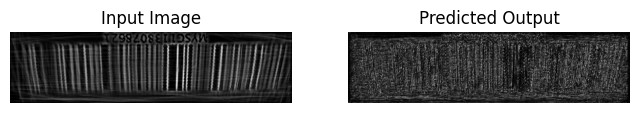

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load model
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
model = StyleTransferUNet()  # Initialize the model
model = nn.DataParallel(model)  # Use multiple GPUs
model.load_state_dict(torch.load("models/unet_se_resnext101_32x4d(8).pth", map_location=device))  
model.to(device)
model.eval()  # Set model to evaluation mode

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for grayscale (-1 to 1)
])

# Function to pad image to the nearest multiple of 32 while keeping aspect ratio
def pad_to_multiple(img_tensor, multiple=32):
    # if img_tensor.dim() == 4:  # If (B, C, H, W), remove batch
    #     img_tensor = img_tensor.squeeze(0)
    _, _, h, w = img_tensor.shape  # (3, H, W) for grayscale
    new_h = (h + multiple - 1) // multiple * multiple  # Round up to nearest multiple
    new_w = (w + multiple - 1) // multiple * multiple
    pad_h = new_h - h
    pad_w = new_w - w
    # Pad (left, right, top, bottom)
    img_padded = F.pad(img_tensor, (0, pad_w, 0, pad_h), mode='constant', value=0)
    return img_padded, pad_h, pad_w  # Return padding values for cropping later

# Function for inference
def predict(image_path, device):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  
    image_tensor = transform(image).unsqueeze(0)  # (1, H, W)

    # Pad the image
    image_tensor, pad_h, pad_w = pad_to_multiple(image_tensor)

    # Ensure batch size > 1 for DataParallel
    if torch.cuda.device_count() > 1:
        image_tensor = image_tensor.repeat(2, 1, 1, 1)  # (2, C, H, W)

    image_tensor = image_tensor.to(device)

    with torch.no_grad():
        output = model(image_tensor)

    # Only take the first output if batch size was increased
    output = output[0] if output.dim() == 4 else output

    output = output.squeeze(0).cpu().numpy()  # (H, W)
    output = ((output + 1) * 127.5).clip(0, 255).astype(np.uint8)
    output = output[: image.shape[0], : image.shape[1]]

    return output


# Example usage
image_path = "test/reconstructed/op_3.png"
output_image = predict(image_path, device)

# Show result
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), cmap="gray")  # Read in grayscale
plt.title("Input Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(output_image, cmap="gray")  # Display output in grayscale
plt.title("Predicted Output")
plt.axis("off")

plt.show()


In [39]:
output_image*2

array([[ 42,  36,   8, ...,  10,  26,  16],
       [ 68,   8,  24, ...,  16,  22,   8],
       [ 64,   4,   2, ...,   0,   2,   0],
       ...,
       [ 44,  44,   4, ...,   0,   2,   2],
       [ 64,  58,  36, ...,   2,  42,  64],
       [144, 104, 162, ...,  10,   4,   2]], dtype=uint8)

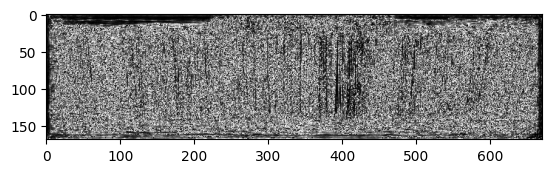

In [44]:
plt.imshow(5*output_image, cmap="gray")

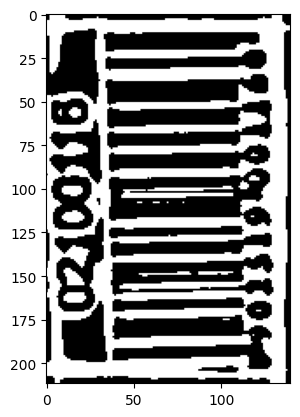

In [66]:
img = cv2.imread("test/reconstructed/nb_4.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.GaussianBlur(img, ksize=(3, 3), sigmaX=0)
thresh = cv2.adaptiveThreshold(
    img, 255, 
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # Or use cv2.ADAPTIVE_THRESH_MEAN_C
    cv2.THRESH_BINARY, 
    101, 2  # Block size and C value
)
plt.imshow(thresh, cmap='gray')

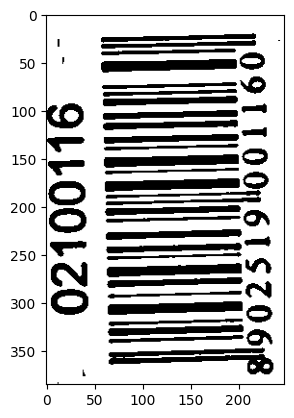

In [67]:
img = cv2.imread("test/target/nb_4.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.GaussianBlur(img, ksize=(3, 3), sigmaX=0)
thresh = cv2.adaptiveThreshold(
    img, 255, 
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # Or use cv2.ADAPTIVE_THRESH_MEAN_C
    cv2.THRESH_BINARY, 
    101, 2  # Block size and C value
)
plt.imshow(thresh, cmap='gray')

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt



# Function to apply Gaussian blur and adaptive thresholding
def preprocess_image(img):
    """Apply Gaussian blur and adaptive thresholding."""
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img, (3, 3), 0)  # Apply Gaussian blur
    img = cv2.adaptiveThreshold(
        img, 255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 
        11, 2  # Block size and C value
    )
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    return img


In [ ]:
import os
os.mkdir("final_images")

In [6]:
root = "train_dataset/reconstructed"
dir = "final_images"
l = os.listdir(root)
for i in l:
    img = preprocess_image(cv2.imread(os.path.join(root, i)))
    cv2.imwrite(f"final_images/{i}", img)

In [9]:
def preprocess_image(img):
    """Apply Gaussian blur and adaptive thresholding."""
    img = cv2.GaussianBlur(img, (3, 3), 0)  # Apply Gaussian blur
    img = cv2.adaptiveThreshold(
        img, 255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 
        11, 2  # Block size and C value
    )
    return img




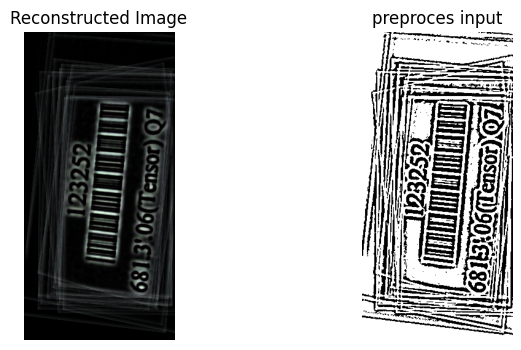

In [15]:
image_path = "test/reconstructed/mlwst_oreily_12.png"
image = cv2.imread(image_path)
# output_image = predict(image_path, device)
img = preprocess_image(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
# Show result
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")  # Read in grayscale
plt.title("Reconstructed Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img, cmap="gray")  # Display output in grayscale
plt.title("preproces input")
plt.axis("off")

plt.show()


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import os

# ========================== UNet-based Model ==========================
class StyleTransferUNet(nn.Module):
    def __init__(self, encoder_name="se_resnext101_32x4d", pretrained=True):
        super(StyleTransferUNet, self).__init__()
        self.unet = smp.Unet(
            encoder_name=encoder_name, 
            encoder_weights="imagenet" if pretrained else None, 
            in_channels=1,  # 1-channel grayscale input
            classes=1
        )
        # Change final activation to Sigmoid for [0,1] output range
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        return self.final_activation(self.unet(x))

# ========================== Image Restoration Loss Function ==========================
class ImageRestorationLoss(nn.Module):
    def __init__(self, alpha=0.8, beta=0.2, gamma=0.1):
        super(ImageRestorationLoss, self).__init__()
        self.alpha = alpha  # Weight for L1 Loss
        self.beta = beta    # Weight for SSIM Loss
        self.gamma = gamma  # Weight for Edge Loss
        self.l1_loss = nn.L1Loss()

    def ssim_loss(self, img1, img2, eps=1e-4):
        """Compute the SSIM loss with added stability constant."""
        mu1 = F.avg_pool2d(img1, kernel_size=3, stride=1, padding=1)
        mu2 = F.avg_pool2d(img2, kernel_size=3, stride=1, padding=1)
        
        sigma1 = F.avg_pool2d(img1**2, 3, 1, 1) - mu1**2 + eps
        sigma2 = F.avg_pool2d(img2**2, 3, 1, 1) - mu2**2 + eps
        sigma12 = F.avg_pool2d(img1 * img2, 3, 1, 1) - mu1 * mu2
        
        C1 = 0.01**2
        C2 = 0.03**2
        
        ssim = ((2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)) / (
            (mu1**2 + mu2**2 + C1) * (sigma1 + sigma2 + C2) + eps)
        return 1 - ssim.mean()

    def edge_loss(self, img1, img2):
        """Compute edge loss using Sobel filters with channel-wise handling."""
        sobel_x = torch.tensor([[-1, 0, 1], 
                                [-2, 0, 2], 
                                [-1, 0, 1]], dtype=torch.float32).view(1, 1, 3, 3).to(img1.device)
        sobel_y = torch.tensor([[-1, -2, -1], 
                                [ 0,  0,  0], 
                                [ 1,  2,  1]], dtype=torch.float32).view(1, 1, 3, 3).to(img1.device)
        
        # Apply to each channel separately using groups
        img1_x = F.conv2d(img1, sobel_x, padding=1, groups=img1.shape[1])
        img1_y = F.conv2d(img1, sobel_y, padding=1, groups=img1.shape[1])
        img2_x = F.conv2d(img2, sobel_x, padding=1, groups=img2.shape[1])
        img2_y = F.conv2d(img2, sobel_y, padding=1, groups=img2.shape[1])
        
        edge1 = torch.sqrt(img1_x**2 + img1_y**2 + 1e-6)
        edge2 = torch.sqrt(img2_x**2 + img2_y**2 + 1e-6)
        return F.l1_loss(edge1, edge2)

    def forward(self, pred, target):
        # No clamping required now since both pred and target should be [0,1]
        l1 = self.l1_loss(pred, target)
        ssim = self.ssim_loss(pred, target)
        edge = self.edge_loss(pred, target)
        total_loss = self.alpha * l1 + self.beta * ssim + self.gamma * edge
        return total_loss

# ========================== Training Function ==========================
def train(model, dataloader, num_epochs=3501, lr=1e-3, device="cuda"):
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    
    # Use the custom ImageRestorationLoss
    loss_fn = ImageRestorationLoss(alpha=0.8, beta=0.2, gamma=0.1).to(device)
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=2000, eta_min=5e-8)
    grad_clip = 1.5
    loss_list = []
    loss_10_list = []

    for epoch in tqdm(range(num_epochs)):
        model.train()
        total_loss = 0
        
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            # Compute custom loss (L1 + SSIM + Edge Loss)
            loss = loss_fn(outputs, targets)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()
            total_loss += loss.item()
            
            # (Optional) Uncomment to log gradient norms for debugging:
            # for name, param in model.named_parameters():
            #     if param.grad is not None:
            #         print(f"{name}: {torch.norm(param.grad).item()}")

        avg_loss = total_loss / len(dataloader)
        scheduler_cosine.step()
        loss_list.append(avg_loss)
    
        # Log learning rate and loss every 10 epochs
        if epoch % 10 == 0 and epoch != 0:
            current_lr = optimizer.param_groups[0]['lr']
            save_model(model)
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, LR: {current_lr:.6f}")
            loss_10_list.append(avg_loss)

    return loss_list, loss_10_list

# ========================== Model Saving Function ==========================
def save_model(model, save_dir="saved_models"):
    os.makedirs(save_dir, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(save_dir, "unet_se_resnext101_32x4d.pth"))
    print(f"Model saved in {save_dir}")

# ========================== Model Initialization ==========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = StyleTransferUNet()  # Initialize the model
# model = nn.DataParallel(model)  # Use multiple GPUs if available
# model.to(device)
# model.load_state_dict(torch.load("/kaggle/input/unet_se_resnext101_32x4d_1000/pytorch/default/1/unet_se_resnext101_32x4d_1000.pth", map_location=device))  

# # Now run training (make sure 'dataloader' is defined)
# l1, l10 = train(model, dataloader)


/home/roy/miniconda3/envs/PyTorch_env/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


torch.Size([1, 1, 169, 671])
(169, 671)


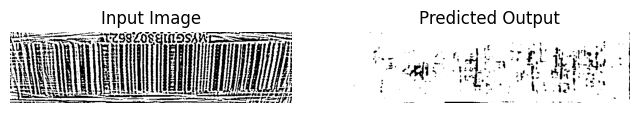

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = StyleTransferUNet()  # Initialize the model
model = nn.DataParallel(model)  # Use multiple GPUs
model.load_state_dict(torch.load("models/unet_se_resnext101_32x4d_4500.pth", map_location=device))  
model.to(device)
model.eval()  # Set model to evaluation mode

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    # transforms.Normalize(mean=[0], std=[0.5])  # Normalize for grayscale (-1 to 1)
])

# Function to apply Gaussian blur and adaptive thresholding
def preprocess_image(img):
    """Apply Gaussian blur and adaptive thresholding."""
    img = cv2.GaussianBlur(img, (3, 3), 0)  # Apply Gaussian blur
    img = cv2.adaptiveThreshold(
        img, 255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 
        11, 2  # Block size and C value
    )
    return img

# Function to pad image to the nearest multiple of 32 while keeping aspect ratio
def pad_to_multiple(img_tensor, multiple=32):
    if img_tensor.dim() == 4:  # If (B, C, H, W), remove batch
        img_tensor = img_tensor.squeeze(0)
    _, h, w = img_tensor.shape  # (C, H, W) for grayscale
    new_h = (h + multiple - 1) // multiple * multiple  # Round up to nearest multiple
    new_w = (w + multiple - 1) // multiple * multiple
    pad_h = new_h - h
    pad_w = new_w - w
    # Pad (left, right, top, bottom)
    img_padded = F.pad(img_tensor, (0, pad_w, 0, pad_h), mode='constant', value=0)
    return img_padded, pad_h, pad_w  # Return padding values for cropping later

# Function for inference
def predict(image_path, device):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    image = preprocess_image(image)  # Apply preprocessing

    image_tensor = transform(image).unsqueeze(0)  # Convert to tensor & normalize
    print(image_tensor.shape)
    # Pad the image
    image_tensor, pad_h, pad_w = pad_to_multiple(image_tensor)
    image_tensor = image_tensor.unsqueeze(0)
    # Ensure batch size > 1 for DataParallel
    if torch.cuda.device_count() > 1:
        image_tensor = image_tensor.repeat(2, 1, 1, 1)  # (2, C, H, W)

    image_tensor = image_tensor.to(device)

    with torch.no_grad():
        output = model(image_tensor)
    # Only take the first output if batch size was increased
    output = output[0] if output.dim() == 4 else output

    output = output.squeeze(0).cpu().numpy()  # (H, W)
    output = ((output + 1) * 127.5).clip(0, 255).astype(np.uint8)
    output = output[: image.shape[0], : image.shape[1]]
    print(output.shape)
    return output

# Example usage
image_path = "test/reconstructed/op_3.png"
output_image = predict(image_path, device)
img = preprocess_image(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE))
# Show result
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap="gray")  # Read in grayscale
plt.title("Input Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(output_image, cmap="gray")  # Display output in grayscale
plt.title("Predicted Output")
plt.axis("off")

plt.show()


In [51]:
import pandas as pd

data = pd.read_csv("output10(1).csv")

In [53]:
import numpy as np
m = list(data)
for i in range (len(m)):
    try:
        print(i, float(m[i]))
    except:
        m[i] = 0.15367652848362923
float_list = np.array(m, dtype=np.float32)

Text(0.5, 0, 'epoches')

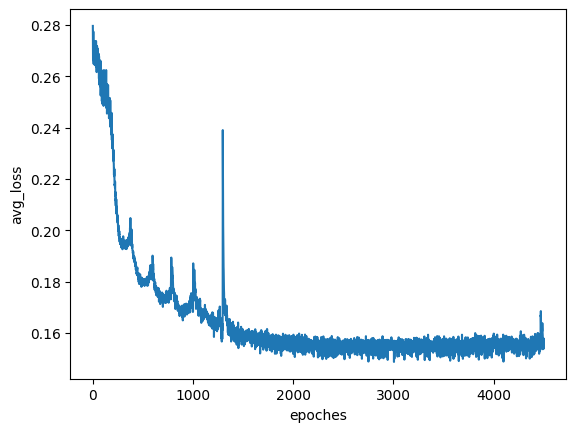

In [ ]:
float = np.concatenate([float_list2, float_list])
plt.plot(float)
plt.ylabel("avg_loss")
plt.xlabel("epoches")

In [44]:
float_list

array([0.27962127, 0.27154064, 0.26626173, ..., 0.16910227, 0.16819508,
       0.16832256], dtype=float32)

In [45]:
float_list2

array([0.18032242, 0.18712983, 0.18206444, ..., 0.1577957 , 0.15385398,
       0.15491487], dtype=float32)

Text(0.5, 0, 'epoches')

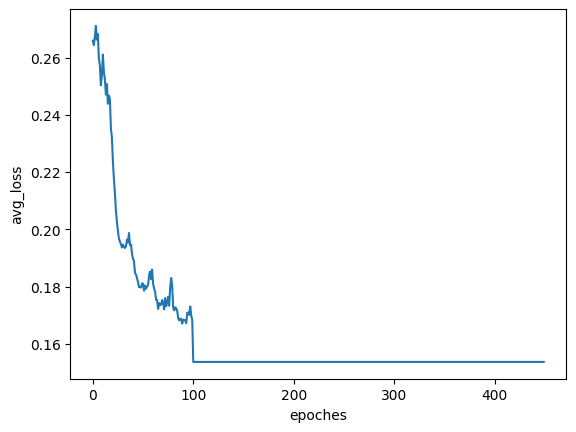

In [54]:
float = np.concatenate([float_list2, float_list])
plt.plot(float)
plt.ylabel("avg_loss")
plt.xlabel("epoches")